# Pricing-Projekt — Wohnungs-/Immobilienpreise 

> **Ziel:** Vorhersage der Kaltmiete (`baseRent`) für Wohnungen in Deutschland basierend auf objekt- und geobezogenen Merkmalen. 

---

## Inhaltsverzeichnis
1. Projektübersicht
2. Setup & Imports
3. Daten einlesen & erste Übersicht
4. Data Cleaning (funktionell)
5. Feature Engineering
6. Explorative Datenanalyse (EDA)
7. Encoding-Strategien (Target-Encoding vs OHE)
8. Train/Test Split
9. Modelle: Baseline, Linear, RandomForest, XGBoost, ANN
10. Evaluation & Vergleich
11. Modellpersistenz
12. Fazit & Nächste Schritte

---

# 1) Projektübersicht

In diesem Projekt untersuche ich, wie sich die **Kaltmiete (`baseRent`)** von Wohnungen in Deutschland zuverlässig vorhersagen lässt.

Als Datengrundlage dient der Kaggle-Datensatz  
**„Apartment Rental Offers in Germany“**, der eine Vielzahl von Immobilienmerkmalen enthält (Lage, Ausstattung, Größe, Baujahr usw.).

Einige Spalten mussten jedoch entfernt werden, da sie:

- sich auf die **Warmmiete** beziehen  
  (z. B. `heatingCosts`, `electricityBasePrice`)
- extrem viele **fehlende Werte** enthalten  
  (z. B. `telekomHybridUploadSpeed`, `electricityKwhPrice`)
- die Zielvariable **implizit vorwegnehmen**  
  (z. B. `baseRentRange`)

Nach dem Entfernen solcher Spalten wurden die verbleibenden Daten weiter aufbereitet:

- **Fehlende Werte** wurden logisch ersetzt (Median/Mode oder durch abgeleitete Werte wie Baujahr/Refurbish-Jahr).  
- **Ausreißer** in numerischen Variablen wurden mithilfe des IQR-Verfahrens begrenzt (Clipping).  
- Zusätzliche Features wurden erstellt, z. B. `Bau_alt` oder `room_ratio`.

Zum Schluss wurden mehrere Modellansätze trainiert und verglichen:

- **Baseline-Modell** (Durchschnittsvorhersage)  
- **Random Forest Regressor**  
- **XGBoost**  
- **Artificial Neural Network (ANN)**  

Diese Modelle ermöglichen eine umfassende Bewertung, welche Algorithmen und welche Merkmale am besten geeignet sind, um **präzise Mietpreisprognosen** für den deutschen Wohnungsmarkt zu erzeugen.




---

## 2) Setup & Imports

In [2]:
# Allgemeine Einstellungen
import warnings
warnings.filterwarnings('ignore')

# Data & ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Keras (für ANN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproduzierbarkeit
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


---

## 3) Daten einlesen & erste Übersicht

In [3]:
df = pd.read_csv('immo_data.csv', low_memory=False)
print('Rows, cols:', df.shape)
df.head()

Rows, cols: (268850, 49)


,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,...,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,...,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,...,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,...,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,...,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

### Überblick über Struktur und Datenqualität 

Die Ausgabe von `df.info()` zeigt, dass der Datensatz aus **268.850 Einträgen** und **49 Spalten** besteht.  
Besonders auffällig ist die **heterogene Datenqualität**:

- Der Datensatz enthält **sehr viele fehlende Werte** in bestimmten Spalten  
  – z. B. `telekomHybridUploadSpeed` (~83 % fehlend),  
  – `noParkSpaces`, `heatingCosts`, `electricityBasePrice`, `electricityKwhPrice`,  
  – sowie Merkmale wie `interiorQual`, `petsAllowed`, `thermalChar`.

- Viele Spalten liegen als **`object`-Typ** vor (z. B. `regio1`, `firingTypes`, `condition`, `street`, `description`).  
  Diese müssen später teilweise kategorisiert oder anders verarbeitet werden.

- Einige Spalten sind **boolsche Flags**, die direkt verwendet werden können (z. B. `balcony`, `cellar`, `lift`, `garden`).

Diese Übersicht ist entscheidend für die weiteren Schritte der Datenvorbereitung, insbesondere für:
- das Entfernen irrelevanter Features,  
- das Imputieren fehlender Werte,  
- die Umwandlung von Datentypen.


In [5]:
df.describe()

,serviceCharge,telekomHybridUploadSpeed,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,yearConstructedRange,...,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
count,261941.000000,45020.0,268850.000000,267018.000000,235492.000000,2.283330e+05,211805.000000,2.688500e+05,93052.000000,211805.000000,...,268850.000000,162344.000000,217541.000000,171118.000000,268850.000000,268850.000000,85518.000000,80711.000000,46846.000000,46846.000000
mean,151.206113,10.0,9.791958,3.389001,28.804928,9.013315e+02,1966.400590,1.069697e+08,1.327634,3.714544,...,2.641261,114.749533,2.122405,3.572319,2.571542,3.070790,76.990866,2013.904536,89.113612,0.199769
std,308.295790,0.0,6.408399,1.964874,16.337151,3.323833e+04,46.992207,1.250093e+07,8.361403,2.738134,...,2.633440,61.653663,3.634934,6.375496,0.937594,1.407127,147.716278,10.963125,5.395805,0.009667
min,0.000000,10.0,0.000000,-12.330000,1.000000,0.000000e+00,1000.000000,2.887174e+07,0.000000,1.000000,...,1.000000,0.100000,-1.000000,0.000000,1.000000,1.000000,0.000000,1015.000000,71.430000,0.170500
25%,95.000000,10.0,6.000000,2.000000,10.000000,4.698000e+02,1950.000000,1.066910e+08,1.000000,1.000000,...,2.000000,79.000000,1.000000,2.000000,2.000000,2.000000,54.000000,2012.000000,90.760000,0.191500
50%,135.000000,10.0,9.000000,3.390000,40.000000,6.500000e+02,1973.000000,1.111584e+08,1.000000,3.000000,...,3.000000,107.000000,2.000000,3.000000,3.000000,3.000000,70.000000,2017.000000,90.760000,0.198500
75%,190.000000,10.0,13.000000,4.570000,40.000000,9.850000e+02,1996.000000,1.137688e+08,1.000000,5.000000,...,3.000000,140.300000,3.000000,4.000000,3.000000,4.000000,90.000000,2019.000000,90.760000,0.205500
max,146118.000000,10.0,121.000000,14.920000,100.000000,1.575154e+07,2090.000000,1.157117e+08,2241.000000,9.000000,...,999.990000,1996.000000,999.000000,999.000000,5.000000,7.000000,12613.000000,2919.000000,90.760000,0.227600


### Auffällige Werte in den Rohdaten

Die Ausgabe von `df.describe()` zeigt mehrere **unrealistische Extremwerte**, die auf Eingabefehler oder nicht bereinigte Datensätze hindeuten. Beispiele:

- `lastRefurbish` hat einen Maximalwert von **2919**, was zeitlich unmöglich ist.  
- `numberOfFloors` erreicht einen Wert von **999**, der in realen Gebäuden nicht vorkommt.  
- `yearConstructed` weist einen Maximalwert von **2090** auf, also ein Jahr in der Zukunft.

Solche Werte deuten auf **Datenqualitätsprobleme** hin und müssen im Rahmen der Bereinigung korrigiert oder durch sinnvolle Grenzwerte (Clipping) ersetzt werden.  
Diese Beobachtung bestätigt, dass eine sorgfältige Datenbereinigung notwendig ist, bevor Modelle trainiert werden.


### Doppeltes Lageschema im Datensatz

Der Datensatz enthält zwei parallele Schemata zur Beschreibung der Lage:

- `geo_bln`, `geo_krs`, `geo_plz`
- `regio1`, `regio2`, `regio3`

Ein Vergleich zeigt:

- `geo_bln` und `regio1` sind für alle Zeilen identisch kodiert.  
- `geo_krs` und `regio2` sind ebenfalls identisch.  
- `geo_plz` und `regio3` unterscheiden sich hingegen:  
  `geo_plz` ist eine numerische Postleitzahl, während `regio3` eine textuelle Regionsbezeichnung (z. B. *Schüren*, *Böhl_Iggelheim*, *Äußere_Neustadt_Antonstadt*) enthält.

Für die Modellierung werden die `geo_*`-Spalten bevorzugt, da sie konsistenter strukturiert sind und sich besser für Encoding-Verfahren eignen.  
Die `regio*`-Spalten werden daher als redundant bzw. weniger geeignet betrachtet und nicht weiter verwendet.

### Auswahl relevanter Ausgangsmerkmale

Nach der ersten Datenexploration (Struktur, fehlende Werte, Extremwerte) wird deutlich, 
dass viele Spalten für die spätere Modellierung nicht geeignet oder redundant sind.  
Um die Bereinigung übersichtlich und zielgerichtet zu gestalten, werden im nächsten Schritt nur 
jene Variablen beibehalten, die für die Vorhersage der Kaltmiete sinnvoll erscheinen.

Die spätere Liste `possible_cols` umfasst:

- **Lageinformationen** (`geo_bln`, `geo_krs`, `geo_plz`)
- **Gebäudedaten** (`yearConstructed`, `yearConstructedRange`, `newlyConst`)
- **Wohnungsmerkmale** (`livingSpace`, `noRooms`, `typeOfFlat`)
- **Ausstattungsmerkmale** (`balcony`, `cellar`, `hasKitchen`, `lift`, `garden`)
- **Parkplatzinformation** (`noParkSpaces`)
- **Zeitvariable** (`date`)
- **Zielvariable** (`baseRent`)

Nicht relevante, stark fehlende oder potenziell leaky Spalten (wie bereits in der Projektübersicht erläutert)
werden in der nachfolgenden Bereinigung bewusst ignoriert, um ein klares und modellrelevantes Feature-Set zu erhalten.



In [6]:
# Datum -> Jahr (handle errors)
df['year'] = pd.to_datetime(df['date'], format='%b%y', errors='coerce').dt.year

# Berechne Bau_alt
# Fülle fehlende yearConstructed mit Median nach Gruppen als robusten Ansatz
df['yearConstructed'] = pd.to_numeric(df['yearConstructed'], errors='coerce')
df['yearConstructed'].fillna(df['yearConstructed'].median(), inplace=True)
# sicherstellen, dass yearConstructed <= year
df.loc[df['yearConstructed'] > df['year'], 'yearConstructed'] = df['year']
df['Bau_alt'] = (df['year'] - df['yearConstructed']).clip(lower=0)

# lastRefurbish -> in Jahre
df['lastRefurbish'] = pd.to_numeric(df['lastRefurbish'], errors='coerce')
df['lastRefurbish'].fillna(df['yearConstructed'], inplace=True)
df.loc[df['lastRefurbish'] > df['year'], 'lastRefurbish'] = df['year']
df['lastRefurbish_in_years'] = (df['year'] - df['lastRefurbish']).clip(lower=0)

### Erstellung zeitbezogener Features (`Bau_alt` und `lastRefurbish_in_years`)

Bevor die fehlenden Werte im Datensatz bereinigt werden, werden zunächst zwei wichtige zeitbezogene Merkmale erstellt:

1. **`Bau_alt`**  
   - Aus dem Inseratsdatum (`date`) und dem Baujahr (`yearConstructed`) wird das Alter der Immobilie berechnet.  
   - Fehlende Baujahre werden durch den Median ersetzt.  
   - Zusätzlich wird sichergestellt, dass das Baujahr nicht nach dem Inseratsjahr liegt.

2. **`lastRefurbish_in_years`**  
   - Aus dem Renovierungsjahr (`lastRefurbish`) und dem Inseratsjahr wird die Zeit seit der letzten Renovierung berechnet.  
   - Fehlende Renovierungsjahre werden durch das Baujahr ersetzt.  
   - Unrealistische Werte (Renovierung in der Zukunft) werden korrigiert.

Durch die frühzeitige Erstellung dieser Features wird gewährleistet, dass spätere Schritte zur Behandlung von fehlenden Werten und Ausreißern auf konsistenten, bereinigten Zeitvariablen basieren.


In [7]:
# Bools in 0/1
bool_cols = ['newlyConst','garden','balcony','cellar','hasKitchen','lift']
for c in bool_cols:
    if c in df.columns:
        df[c] = df[c].map({True:1, False:0}).fillna(0).astype(int)

### Umwandlung boolescher Variablen

Die booleschen Merkmale (`newlyConst`, `garden`, `balcony`, `cellar`, `hasKitchen`, `lift`)
werden in numerische Werte (0/1) umgewandelt, damit sie von den späteren Machine-Learning-Modellen korrekt verarbeitet werden können.
Diese Transformation erfolgt früh im Preprocessing, da sie unabhängig von der Behandlung fehlender Werte und der Ausreißeranalyse ist.


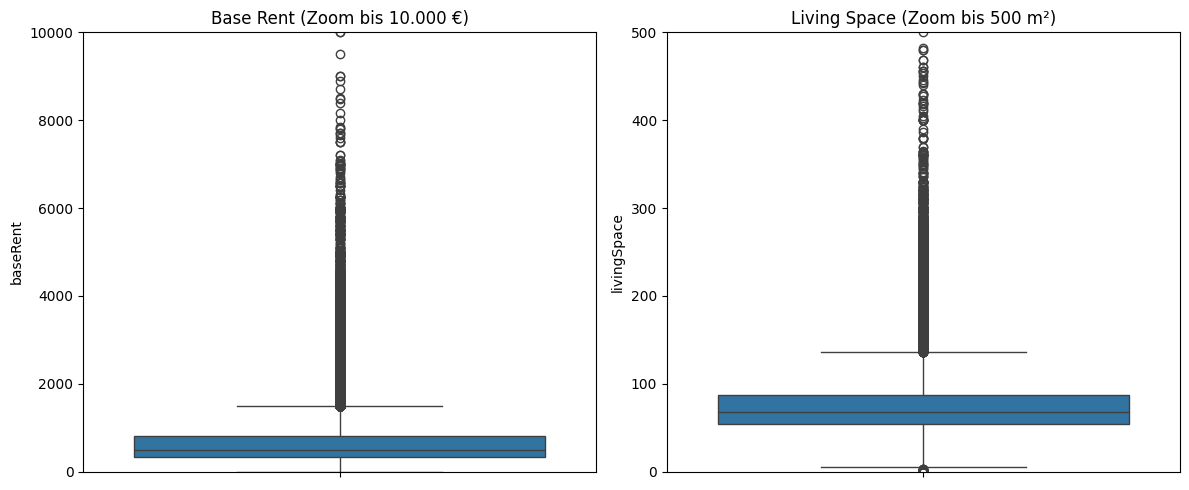

baseRent < 100: 212
baseRent > 2000: 5177
livingSpace > 150: 6829
livingSpace < 10: 132
livingSpace > 150 & baseRent > 2000: 2543


In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(y=df['baseRent'], ax=ax[0])
ax[0].set_title('Base Rent (Zoom bis 10.000 €)')
ax[0].set_ylim(0, 10000)

sns.boxplot(y=df['livingSpace'], ax=ax[1])
ax[1].set_title('Living Space (Zoom bis 500 m²)')
ax[1].set_ylim(0, 500)

plt.tight_layout()
plt.show()

# Ausreißer-Anzahl berechnen
print(f"baseRent < 100: {(df['baseRent'] < 100).sum()}")
print(f"baseRent > 2000: {(df['baseRent'] > 2000).sum()}")
print(f"livingSpace > 150: {(df['livingSpace'] > 150).sum()}")
print(f"livingSpace < 10: {(df['livingSpace'] < 10).sum()}")
print(f"livingSpace > 150 & baseRent > 2000: {((df['livingSpace'] > 150) & (df['baseRent'] > 2000)).sum()}")

### Verteilung von Kaltmiete und Wohnfläche & erste Ausreißeranalyse

Die beiden Boxplots zeigen die Verteilung von

- **Kaltmiete (`baseRent`)** (links, bis 10.000 € gezoomt) und  
- **Wohnfläche (`livingSpace`)** (rechts, bis 500 m² gezoomt).

Man erkennt dabei sehr viele **extreme Werte nach oben**, also Angebote mit:
- ungewöhnlich hoher Miete (z. B. deutlich > 2.000 €),
- sehr großer Wohnfläche (z. B. > 150 m²),
- oder einer Kombination aus beidem.

Die Textausgabe unter der Grafik zählt, wie viele Beobachtungen in diese Bereiche fallen  
(z. B. `baseRent < 100`, `baseRent > 2000`, `livingSpace > 150` etc.).  

Diese Auswertung bestätigt, dass der Datensatz **viele Ausreißer** enthält, die für ein robustes Modell später
entweder begrenzt (Clipping) oder gefiltert werden sollten. Damit wird verhindert, dass wenige extreme Angebote
die Schätzung der „typischen“ Miete verzerren.


In [8]:
print(df['typeOfFlat'].isna().sum())
df['typeOfFlat'].unique()

36614


array(['ground_floor', 'apartment', 'other', nan, 'roof_storey',
       'raised_ground_floor', 'terraced_flat', 'half_basement',
       'maisonette', 'penthouse', 'loft'], dtype=object)

Für die Spalte `typeOfFlat` gibt es **36.614 fehlende Werte**.  
Da es sich dabei überwiegend um allgemeine Wohnungsangebote handelt und keine spezifische Bauart erkennbar ist, werden die fehlenden Einträge als **„other“** kategorisiert.  
So gehen keine Datenpunkte verloren und die Kategorie bleibt konsistent nutzbar.


In [10]:
df['typeOfFlat'] = df['typeOfFlat'].fillna('other')

In [12]:
print(df['noParkSpaces'].isna().sum())
df['noParkSpaces'].unique()

175798


array([1.000e+00, 2.000e+00,       nan, 2.700e+01, 0.000e+00, 3.000e+00,
       4.000e+00, 2.500e+01, 3.100e+01, 3.000e+01, 5.000e+00, 1.200e+01,
       5.000e+01, 1.800e+01, 4.800e+01, 2.200e+01, 1.500e+01, 4.600e+01,
       8.000e+01, 1.300e+01, 2.600e+01, 1.900e+01, 2.000e+01, 2.400e+01,
       3.300e+01, 8.000e+00, 8.300e+01, 1.400e+01, 1.500e+02, 6.000e+01,
       6.000e+00, 9.000e+00, 7.000e+00, 1.000e+01, 6.500e+01, 1.100e+01,
       9.500e+01, 7.500e+01, 1.600e+01, 1.300e+02, 9.300e+01, 4.000e+01,
       7.000e+01, 3.600e+01, 1.700e+01, 9.900e+01, 8.200e+01, 2.300e+01,
       3.800e+01, 9.000e+01, 8.500e+01, 2.100e+01, 3.900e+01, 2.800e+01,
       4.500e+01, 3.500e+01, 6.400e+01, 5.400e+01, 8.700e+01, 5.500e+01,
       1.260e+02, 6.100e+01, 3.400e+01, 3.200e+02, 8.100e+01, 7.600e+01,
       5.900e+01, 3.700e+01, 7.300e+01, 3.100e+02, 2.241e+03, 5.800e+01])

Für die Spalte `noParkSpaces` gibt es rund 175.000 fehlende Werte und gleichzeitig einige sehr hohe, teilweise unrealistische Werte  
(z. B. deutlich über 100 oder sogar über 1000 Parkplätze).

Da eine fehlende Angabe **nicht automatisch** bedeutet, dass keine Parkplätze vorhanden sind, werden die NaN-Werte nicht als `0`
interpretiert. Stattdessen wird:

- eine Indikator-Spalte `noParkSpaces_missing` angelegt, die speichert, ob die ursprüngliche Angabe fehlte (`1`) oder vorhanden war (`0`), und  
- `noParkSpaces` selbst mit `0` aufgefüllt, damit die Variable als numerisches Feature im Modell verwendet werden kann.

In [13]:
df['noParkSpaces_missing'] = (df['noParkSpaces'].isna()).astype(int)
df['noParkSpaces'] = df['noParkSpaces'].fillna(0)
df['noParkSpaces'] = df['noParkSpaces'].clip(0, 20)


### Behandlung extremer Werte in `noParkSpaces`

Nachdem die fehlenden Werte korrekt über einen Missing-Indikator erfasst wurden, wird `noParkSpaces` zusätzlich
auf einen realistischen Wertebereich begrenzt. Werte über 20 Parkplätzen sind für Wohnungsangebote im
Regelfall unrealistisch und entstehen meist durch Eingabefehler oder durch Daten, die eher zu Gewerbeobjekten gehören.

Durch das Clipping auf den Bereich **0 bis 20** wird verhindert, dass wenige extreme Ausreißer das Modell verzerren,
während gleichzeitig alle relevanten Informationen über Parkplätze erhalten bleiben.


noRooms: 8061 Ausreißer (von 268850)
lastRefurbish_in_years: 12580 Ausreißer (von 268850)
livingSpace: 11459 Ausreißer (von 268850)
Bau_alt: 23920 Ausreißer (von 268850)


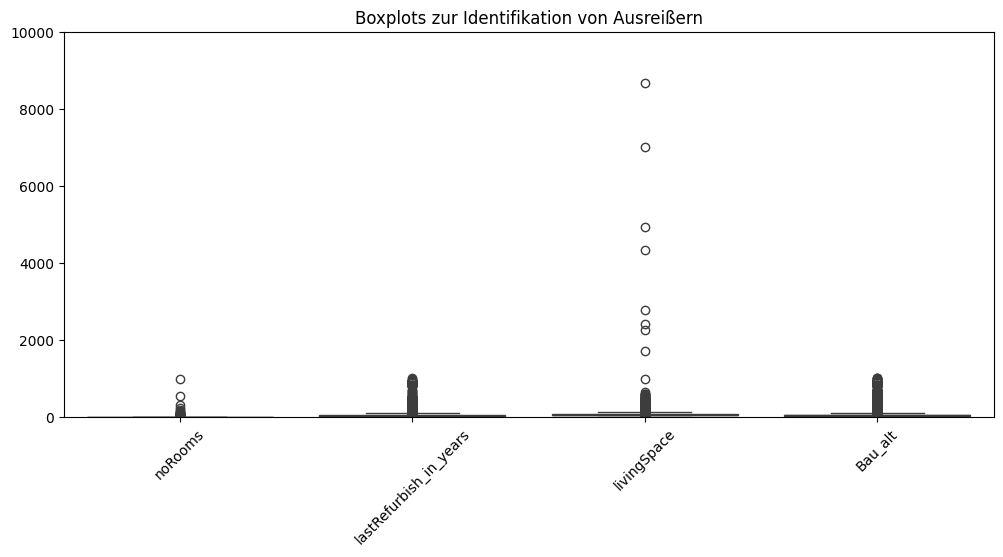

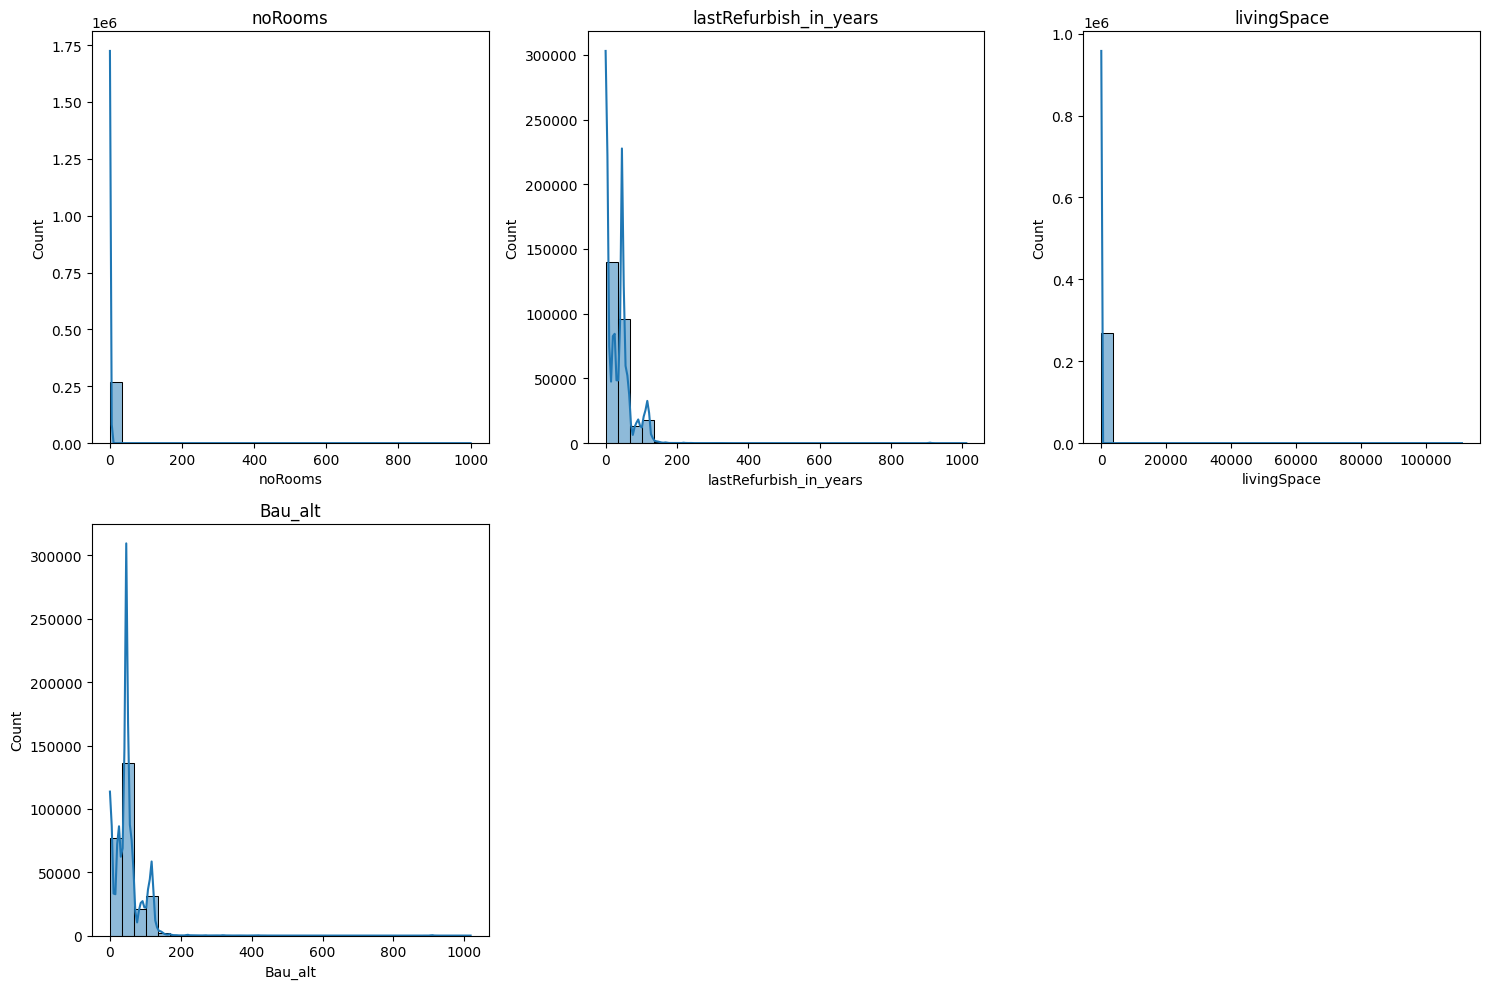

In [14]:
import math
# kontinuierliche Spalten auswählen
cont_cols = ['noRooms', 'lastRefurbish_in_years', 'livingSpace', 'Bau_alt']

# IQR-Ausreißer identifizieren
for col in cont_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} Ausreißer (von {len(df)})")

fig, ax = plt.subplots(1, 1, figsize=(12,5))
sns.boxplot(data=df[cont_cols], ax=ax)
ax.set_title("Boxplots zur Identifikation von Ausreißern")
ax.set_ylim(0, 10000)
plt.xticks(rotation=45)
plt.show()


n = len(cont_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(15, 10))
for i, col in enumerate(cont_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

### Ausreißeranalyse der kontinuierlichen Variablen

Für die kontinuierlichen Merkmale  
`noRooms`, `lastRefurbish_in_years`, `livingSpace` und `Bau_alt`
wurde das IQR-Verfahren verwendet, um Ausreißer zu identifizieren.

Die Anzahl der erkannten Ausreißer je Spalte:

- `noRooms`: 8.061 Ausreißer (ca. 3 % der Daten)  
- `lastRefurbish_in_years`: 12.580 Ausreißer (ca. 5 %)  
- `livingSpace`: 11.459 Ausreißer (ca. 4 %)   
- `Bau_alt`: 23.920 Ausreißer (ca. 9 %)

Die Boxplots und Histogramme zeigen durchgängig **stark rechtsschiefe Verteilungen** mit einzelnen extrem hohen Werten
(z. B. sehr viele Zimmer, außergewöhnlich große Wohnflächen oder sehr alte Gebäude).
Solche Extremwerte sind für normale Wohnungsangebote untypisch und können die Modellschätzung stark verzerren.

Auf Basis dieser Analyse werden die betroffenen Variablen im nächsten Schritt mithilfe von **IQR-basiertem Clipping**
auf einen realistischen Wertebereich begrenzt, damit Ausreißer das Training der Modelle nicht dominieren.


In [15]:
# Ausreißer clipping via IQR für kontinuierliche Spalten
cont_cols = ['noRooms','lastRefurbish_in_years','livingSpace','Bau_alt']
for col in cont_cols:
    if col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[col] = df[col].clip(lower, upper)

### IQR-basiertes Clipping für kontinuierliche Variablen

Für die kontinuierlichen Merkmale `noRooms`, `lastRefurbish_in_years`, `livingSpace` und `Bau_alt`
wurde das IQR-Verfahren verwendet, um extreme Werte zu begrenzen und deren Einfluss auf die Modelle zu reduzieren.  
Da diese Variablen eine typische rechtsschiefe Verteilung mit einzelnen, klar erkennbaren Ausreißern aufweisen,
eignet sich das IQR-Clipping gut, um unrealistische Extremwerte in einen plausiblen Wertebereich zurückzuführen.


---

## 4) Data Cleaning (funktionell)
> Wir definieren eine saubere, dokumentierte Funktion `clean_data(df)` die:

- nur die relevanten Spalten auswählt  
- Lagevariablen (`geo_bln`, `geo_krs`, `geo_plz`) korrekt als kategoriale Merkmale setzt  
- Datumsangaben parst und das Inseratsjahr extrahiert  
- neue zeitbasierte Features erzeugt (`Bau_alt`, `lastRefurbish_in_years`)  
- fehlende Werte nach plausibler Domänenlogik füllt  
- einen Missing-Indikator für `noParkSpaces` erzeugt  
- numerische Ausreißer mittels IQR-Clipping reduziert  
- boolean-Spalten in 0/1 umwandelt  
- logisches Clipping für Parkplatzanzahl (0–20) implementiert  
- ein neues Schnitt-Feature (`room_ratio`) konstruiert  
- Hilfsspalten am Ende entfernt  
- und damit einen vollständig bereinigten, modellfertigen Datensatz zurückgibt



In [1]:
def clean_data(df):
    """
    Bereinigt und transformiert den Immobilien-Datensatz für das spätere Modelltraining.

    Schritte:
    - Auswahl relevanter Ausgangsmerkmale
    - Setzen der Lagevariablen (geo_*) auf kategorialen Datentyp
    - Extraktion zeitbasierter Features (Bau_alt, lastRefurbish_in_years)
    - Plausibilitätsfilter für Miete und Wohnfläche
    - Behandlung fehlender Werte nach plausibler Domänenlogik
    - Erzeugung eines Missing-Indikators für noParkSpaces
    - Logisches Clipping für Parkplatzanzahl (0–20)
    - Umwandlung boolescher Variablen in numerische Werte (0/1)
    - IQR-basiertes Clipping für kontinuierliche Variablen
    - Feature Engineering: room_ratio (Wohnfläche pro Zimmer)
    - Entfernen von Hilfs- und Zwischenvariablen

    Parameter
    ----------
    df : pandas.DataFrame
        Rohdatensatz wie aus Kaggle geladen.

    Returns
    -------
    pandas.DataFrame
        Bereinigter, modellfertiger Datensatz.
    """
    
    df = df.copy()

    # ---------------------------------------
    # 1) Auswahl relevanter Ausgangsmerkmale
    # ---------------------------------------
    possible_cols = [
        'geo_bln', 'geo_krs', 'geo_plz',
        'newlyConst','yearConstructed', 'lastRefurbish',
        'garden', 'balcony', 'noRooms', 'cellar',
        'hasKitchen', 'livingSpace', 'typeOfFlat', 'lift',
        'noParkSpaces', 'date', 'baseRent'
    ]
    df = df.loc[:, df.columns.intersection(possible_cols)].copy()

    # ---------------------------------------
    # 2) Lagevariablen als kategorial kennzeichnen
    # ---------------------------------------
    if 'geo_bln' in df.columns:
        df['geo_bln'] = df['geo_bln'].astype('category')
    if 'geo_krs' in df.columns:
        df['geo_krs'] = df['geo_krs'].astype('category')
    if 'geo_plz' in df.columns:
        # PLZ ist inhaltlich kategorial, auch wenn sie numerisch aussieht
        df['geo_plz'] = df['geo_plz'].astype(str).astype('category')

    # ---------------------------------------
    # 3) Datumsverarbeitung: Jahr aus date
    # ---------------------------------------
    df['year'] = pd.to_datetime(
        df['date'],
        format='%b%y',
        errors='coerce'
    ).dt.year

    # ---------------------------------------
    # 4) Baujahr & Renovierung bereinigen + Zeit-Features
    # ---------------------------------------
    # yearConstructed
    df['yearConstructed'] = pd.to_numeric(df['yearConstructed'], errors='coerce')
    df['yearConstructed'].fillna(df['yearConstructed'].median(), inplace=True)
    # Baujahr darf nicht nach dem Inseratsjahr liegen
    df.loc[df['yearConstructed'] > df['year'], 'yearConstructed'] = df['year']
    df['Bau_alt'] = (df['year'] - df['yearConstructed']).clip(lower=0)

    # lastRefurbish -> Jahre seit letzter Renovierung
    df['lastRefurbish'] = pd.to_numeric(df['lastRefurbish'], errors='coerce')
    df['lastRefurbish'].fillna(df['yearConstructed'], inplace=True)
    df.loc[df['lastRefurbish'] > df['year'], 'lastRefurbish'] = df['year']
    df['lastRefurbish_in_years'] = (df['year'] - df['lastRefurbish']).clip(lower=0)

    # ---------------------------------------
    # 5) Plausibilitätsfilter für Miete & Wohnfläche
    # ---------------------------------------
    df = df[(df['baseRent'] >= 50) & (df['baseRent'] <= 2000)]
    df = df[(df['livingSpace'] >= 10) & (df['livingSpace'] <= 150)]

    # ---------------------------------------
    # 6) Fehlende Werte behandeln
    # ---------------------------------------
    # Parkplatz: Missing-Indikator + Füllung
    df['noParkSpaces_missing'] = df['noParkSpaces'].isna().astype(int)
    df['noParkSpaces'] = df['noParkSpaces'].fillna(0)
    df['noParkSpaces'] = df['noParkSpaces'].clip(0, 20)  # logisches Clipping

    # Wohnungstyp: fehlende Werte -> 'other'
    df['typeOfFlat'] = df['typeOfFlat'].fillna('other')

    # ---------------------------------------
    # 7) Boolesche Variablen in 0/1 umwandeln
    # ---------------------------------------
    bool_cols = ['newlyConst', 'garden', 'balcony', 'cellar', 'hasKitchen', 'lift']
    for c in bool_cols:
        if c in df.columns:
            df[c] = df[c].map({True: 1, False: 0}).fillna(0).astype(int)

    # ---------------------------------------
    # 8) IQR-Clipping für kontinuierliche Variablen
    # ---------------------------------------
    cont_cols = ['noRooms', 'lastRefurbish_in_years', 'livingSpace', 'Bau_alt']
    for col in cont_cols:
        if col in df.columns:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            df[col] = df[col].clip(lower, upper)

    # ---------------------------------------
    # 9) Feature Engineering: room_ratio
    # ---------------------------------------
    # Verhältnis Wohnfläche / Zimmerzahl als Maß für „Großzügigkeit“ des Schnitts
    no_rooms_safe = df['noRooms'].replace(0, np.nan)
    df['room_ratio'] = df['livingSpace'] / no_rooms_safe

    # Fehlende room_ratio (z. B. durch 0 Zimmer) mit robustem Ersatzwert füllen
    median_noRooms = df['noRooms'].median()
    df['room_ratio'].fillna(df['livingSpace'] / median_noRooms, inplace=True)

    # ---------------------------------------
    # 10) Entfernen von Hilfs- und Zwischenvariablen
    # ---------------------------------------
    drop_cols = ['date', 'year', 'yearConstructed', 'lastRefurbish']
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

    return df


### Anwendung der Bereinigungsfunktion

Im nächsten Schritt wird der ursprüngliche Rohdatensatz erneut eingelesen
und anschließend durch die Funktion `clean_data(df)` verarbeitet.  
Damit wird sichergestellt, dass alle Bereinigungsschritte konsistent und in der
richtigen Reihenfolge auf die Originaldaten angewendet werden.


In [20]:
df = pd.read_csv('immo_data.csv', low_memory=False)
df = clean_data(df)

Der Datensatz ist nun vollständig bereinigt und kann für Encoding, Train-Test-Split
und Modelltraining verwendet werden.


---

## 5) Feature Engineering

Ein zusätzliches abgeleitetes Merkmal ist das Verhältnis von Wohnfläche zu Zimmerzahl:

**`room_ratio = livingSpace / noRooms`**

Dieses Feature beschreibt, wie „großzügig“ eine Wohnung geschnitten ist.
Zum Beispiel haben zwei Wohnungen mit 60 m² sehr unterschiedliche Schnitte, wenn eine 2 Zimmer und die andere 3 Zimmer hat.

Die Berechnung erfolgt in der Bereinigungsfunktion `clean_data(df)`:
- Division durch 0 wird verhindert (`noRooms == 0`)
- fehlende Werte werden durch Gruppenmedian ersetzt
- das Feature wird nach allen Bereinigungsschritten erzeugt

Dieses Merkmal kann von Modellen gut genutzt werden, um Grundrisseffizienz einzubeziehen.


---

## 6) EDA (Kurz, übersichtlich)

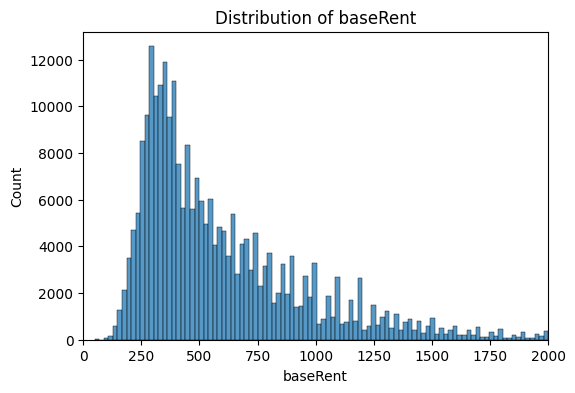

In [21]:
plt.figure(figsize=(6,4))
sns.histplot(df['baseRent'], bins=100)
plt.title('Distribution of baseRent')
plt.xlim(0,2000)
plt.show()


### Verteilung der Zielvariable `baseRent`

Die Verteilung der Kaltmiete (`baseRent`) zeigt eine deutlich rechtsschiefe Form, was bei Miet- und Preisdaten typisch ist.  
Die meisten Inserate liegen im Bereich von **200–600 €**, mit einem klaren Peak um etwa **300–450 €**.  
Nach oben hin fällt die Häufigkeit kontinuierlich ab, und oberhalb von **1500 €** treten nur noch wenige Beobachtungen auf.

Da in der Bereinigung Mieten über 2000 € entfernt wurden, zeigt die Verteilung nun ein plausibles,
modellfreundliches Spektrum ohne extreme Ausreißer. Diese Darstellung bestätigt, dass `baseRent`
nach dem Cleaning stabil und gut analysierbar ist.



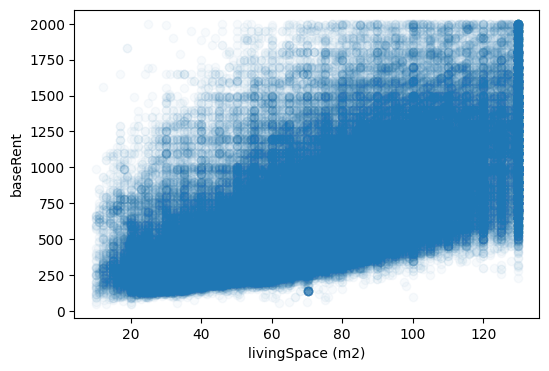

In [22]:
# livingSpace vs baseRent (log-log optional)
plt.figure(figsize=(6,4))
plt.scatter(df['livingSpace'], df['baseRent'], alpha=0.03)
plt.xlabel('livingSpace (m2)')
plt.ylabel('baseRent')
plt.show()

### Zusammenhang zwischen Wohnfläche und Kaltmiete

Der Scatterplot zeigt den erwarteten positiven Zusammenhang zwischen Wohnfläche (`livingSpace`)
und Kaltmiete (`baseRent`). Trotz der hohen Punktzahl (daher die starke Überlagerung)
ist klar erkennbar:

- kleinere Wohnungen (10–40 m²) liegen fast ausschließlich im unteren Mietsegment  
  zwischen ca. 200–600 €,
- mit zunehmender Wohnfläche steigt die Miete kontinuierlich,
- die Streuung nimmt mit der Größe zu: große Wohnungen haben eine größere Preisbandbreite,
- oberhalb von ca. 100 m² treten verstärkt höhere Mieten auf, teilweise nahe der oberen
  Clipping-Grenze von 2000 €.

Der Plot zeigt damit, dass Wohnfläche ein starkes, aber nicht perfekt lineares
Merkmal für die Mietpreisbestimmung ist — was später im Modell durch nichtlineare
Algorithmen (Random Forest, XGBoost, ANN) gut aufgefangen werden kann.



### Korrelation zwischen numerischen Merkmalen

Um die Beziehungen zwischen den numerischen Variablen im bereinigten Datensatz besser zu verstehen,
wird eine Korrelationsmatrix erstellt. Diese zeigt, welche Features positiv oder negativ miteinander
zusammenhängen und hilft einzuschätzen, welche Merkmale potenziell wichtig für die Vorhersage der
Kaltmiete sein könnten.


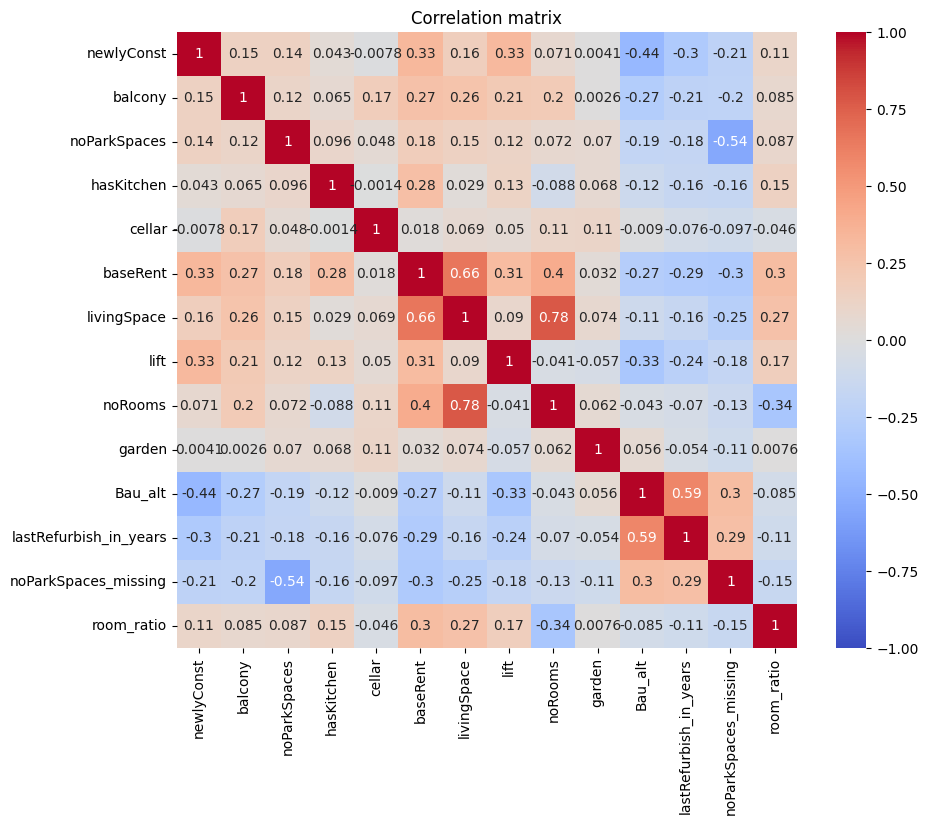

In [23]:
num = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(num.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

##  Interpretation der Korrelationsmatrix

Die Korrelationsmatrix zeigt die linearen Zusammenhänge zwischen den numerischen Merkmalen des Datensatzes.  
Wichtige Erkenntnisse:

### **1. Wohnfläche als stärkster Preisfaktor**
- **`livingSpace` korreliert am stärksten mit der Kaltmiete** (`baseRent`, ~0.66).  
  → Größere Wohnungen sind klar teurer.

### **2. Grundrissqualität: `room_ratio`**
- **`room_ratio`** (Wohnfläche pro Zimmer) zeigt eine **moderate positive Korrelation** zur Miete (~0.32).  
  → Großzügiger geschnittene Wohnungen haben tendenziell höhere Preise.

### **3. Alter & Renovierung beeinflussen die Miete spürbar**
- **`Bau_alt`** hat eine **negative** Korrelation zu `baseRent` (~–0.31).  
  → Je älter das Gebäude, desto günstiger die Miete.
- **`lastRefurbish_in_years`** korreliert ebenfalls negativ (~–0.29).  
  → Kürzlich renovierte Wohnungen sind teurer.

### **4. Starke interne Beziehung: `livingSpace` ↔ `noRooms`**
- Es besteht eine **sehr starke positive Korrelation** zwischen  
  **Wohnfläche (`livingSpace`)** und **Zimmeranzahl (`noRooms`)** (~0.78).  
  → Größere Wohnungen haben erwartungsgemäß mehr Zimmer.

  Diese hohe Multikollinearität ist relevant:
  - lineare Modelle können dadurch beeinträchtigt werden (VIF),
  - beide Variablen tragen ähnliche Information,
  - das Feature **`room_ratio`** hilft, diese Beziehung sinnvoll zu normalisieren
    (kompakte vs. großzügige Grundrisse).

### **5. Umgang mit fehlenden Parkplatzangaben**
- **`noParkSpaces_missing`** ist **negativ** korreliert mit `noParkSpaces` (–0.54).  
  → Wenn die Stellplatzanzahl fehlt, liegt oft tatsächlich kein Stellplatz vor.  
  → Dieses Feature trägt also nützliche Information.

### **6. Weitere Merkmale**
- Alle übrigen Variablen zeigen nur **schwache lineare Zusammenhänge**.  
- Das deutet darauf hin, dass **nichtlineare Modelle** (Random Forest, XGBoost, ANN) später zusätzliche Muster besser erfassen können.



noRooms: 0 Ausreißer (nach Clipping)
lastRefurbish_in_years: 0 Ausreißer (nach Clipping)
livingSpace: 0 Ausreißer (nach Clipping)
Bau_alt: 0 Ausreißer (nach Clipping)


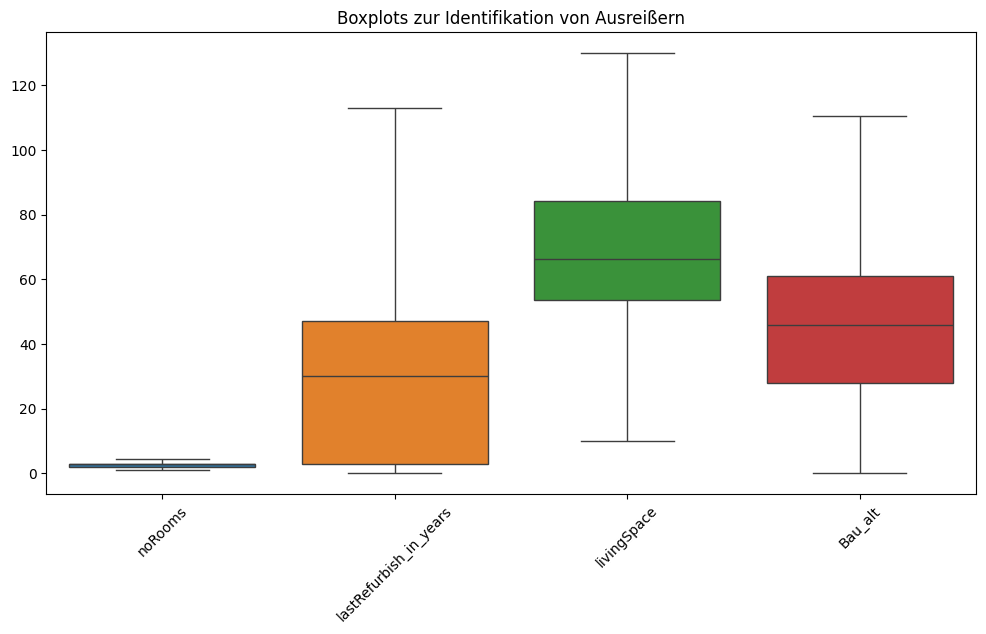

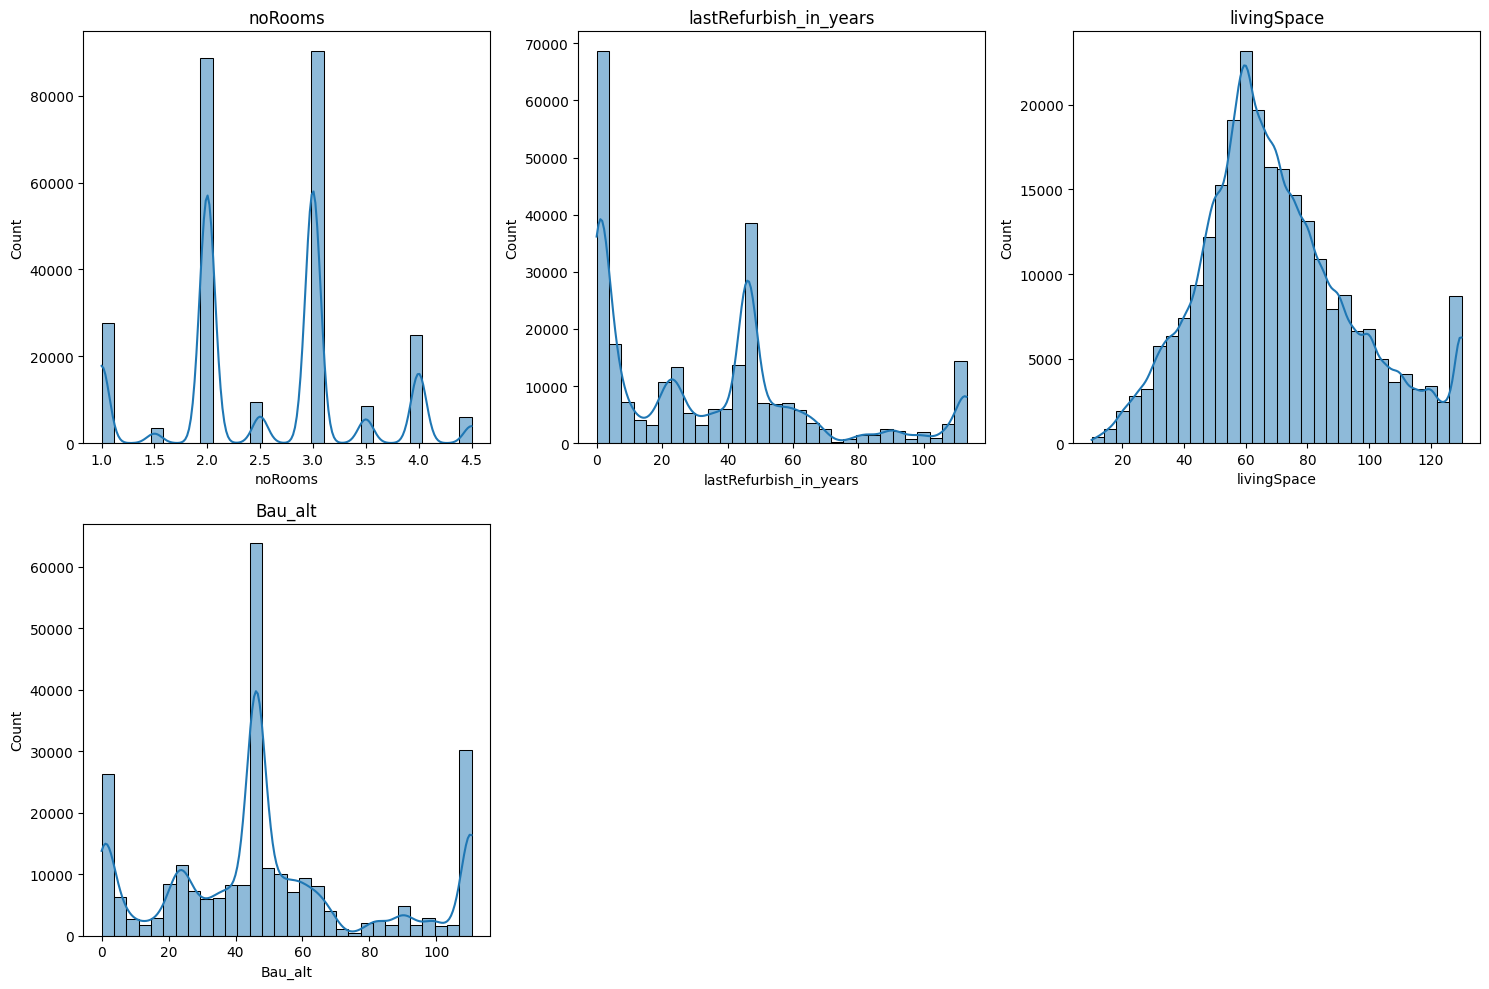

In [34]:
cont_cols = ['noRooms', 'lastRefurbish_in_years', 'livingSpace','Bau_alt']

for col in cont_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} Ausreißer (nach Clipping)")
    
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[cont_cols])
plt.title("Boxplots zur Identifikation von Ausreißern")
plt.xticks(rotation=45)
plt.show()

n = len(cont_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(15, 10))
for i, col in enumerate(cont_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

##  Überprüfung der Daten nach der Bereinigung (`clean_data`)

Nach Anwendung der Funktion `clean_data()` wurden die kontinuierlichen Merkmale  
**`noRooms`, `lastRefurbish_in_years`, `livingSpace` und `Bau_alt`** auf Ausreißer untersucht.  
Dazu wurden die klassischen IQR-Grenzen (1.5 × IQR) verwendet.

###  Ergebnis der Ausreißer-Analyse
Die Boxplots zeigen, dass **alle Extremwerte erfolgreich geclippt** wurden.  
Die Daten liegen nun vollständig innerhalb der definierten IQR-Grenzen, was zu:

- stabileren statistischen Auswertungen,
- robusteren Korrelationen,
- besseren Voraussetzungen für lineare Modelle
- und weniger Verzerrung durch extreme Einzelwerte führt.

###  Verteilung nach dem Clipping

Die Histogramme verdeutlichen, dass:
- die **Verteilungen realistischer und glatter** wirken,
- keine künstlichen Lücken oder scharfen Einschnitte entstanden sind,
- typische Muster deutlicher hervortreten  
  (z. B. Cluster bei `noRooms`, typische Baujahrs-Häufungen, lognormalartige Wohnflächenverteilung).

Durch diese Bereinigung sind die kontinuierlichen Variablen nun **modellbereit** und enthalten deutlich weniger Rauschen.  
Dies bildet eine saubere Grundlage für Feature Engineering, Modelltraining und weitere Analysen.


---

## 7) Train/Test Split

Für die Modellierung wird der Datensatz in **Trainings-** und **Testdaten** aufgeteilt.  
Der Trainingssatz (80 %) dient zum Fitten des Modells, während der Testsatz (20 %) zur  
**unabhängigen Evaluierung** genutzt wird. Dadurch lässt sich sicherstellen, dass die  
Modellleistung realistisch eingeschätzt wird und keine Überanpassung (Overfitting) entsteht.

- **X** enthält alle erklärenden Variablen (Features)  
- **y** ist die Zielvariable (`baseRent`)  
- `random_state` garantiert Reproduzierbarkeit der Ergebnisse  
- Ein 80/20-Split ist ein etablierter Standard im Machine Learning


In [25]:
X = df.drop('baseRent', axis=1)
y = df['baseRent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

---

##  8) Encoding-Strategien

Für die Modellierung müssen kategoriale Merkmale in numerische Werte umgewandelt werden.  
Da der Datensatz sowohl **große** als auch **kleine** Kategorien enthält, werden zwei unterschiedliche Strategien genutzt:

###  8a) Target Encoding für hochkardinale Merkmale
Die Variablen **`geo_plz`** (Postleitzahl) und **`geo_krs`** (Landkreis) besitzen sehr viele unterschiedliche Ausprägungen.  
Ein One-Hot-Encoding würde hier:
- zu **tausenden Dummy-Spalten** führen,
- das Modell unnötig aufblasen,
- das Risiko von Overfitting erhöhen.

Daher wird **Target Encoding** eingesetzt.  
Dabei wird jede Kategorie durch den **durchschnittlichen Zielwert (`baseRent`)** ersetzt, der für diese Kategorie beobachtet wurde.  
Vorteile:
- kompaktere Darstellung,
- keine hohe Dimensionalität,
- oft bessere Modellleistung bei geografischen Merkmalen,
- sinnvoll bei Preisprognosen (starke ortsabhängige Mietstruktur).

Wichtig:
- Der Encoder wird **nur auf `X_train` gefittet**, um Leaking zu vermeiden.
- `X_test` wird anschließend mit denselben Regeln transformiert.

Damit sind die geografischen Merkmale nun modellfähig und enthalten gleichzeitig wertvolle ortsspezifische Preisinformation.


In [27]:
from category_encoders.target_encoder import TargetEncoder

te_cols = ['geo_plz', 'geo_krs']

encoder = TargetEncoder(cols=te_cols)
encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

### 8b) One-Hot-Encoding für niedrig-kardinale Kategorien

Neben den großen geografischen Kategorien gibt es Merkmale mit **wenigen, überschaubaren Ausprägungen**,  
wie **`typeOfFlat`** und **`geo_bln`** (Bundesland).  
Für solche Variablen ist ein **One-Hot-Encoding (OHE)** die geeignete Wahl.

Warum OHE hier sinnvoll ist:
- Es entstehen nur wenige Dummy-Variablen → keine Dimensionsprobleme  
- Die Kodierung ist eindeutig interpretierbar  
- Für Modelle wie lineare Regression, Baumverfahren oder neuronale Netze problemlos nutzbar  
- `handle_unknown='ignore'` stellt sicher, dass unbekannte Kategorien im Testset korrekt verarbeitet werden

In diesem Schritt:
- wird per `ColumnTransformer` nur ein Teil der Spalten per OHE encodiert  
- alle anderen Features (`remainder='passthrough'`) bleiben unverändert  
- `X_train` wird zum Fitten des Encoders genutzt  
- `X_train` und `X_test` werden anschließend **konsistent** transformiert  
- die Ausgaben werden in DataFrames mit sauberen Feature-Namen zurückgeschrieben (`get_feature_names_out()`)

Damit sind die niedrig-kardinalen kategorischen Variablen für die Modellierung vollständig numerisch aufbereitet.


In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
cat_cols_small = ['typeOfFlat', 'geo_bln']

ct = ColumnTransformer(
    [('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols_small)],
    remainder='passthrough'
)

ct.fit(X_train)

X_train_enc = pd.DataFrame(
    ct.transform(X_train),
    columns=ct.get_feature_names_out(),
    index=X_train.index
)

X_test_enc = pd.DataFrame(
    ct.transform(X_test),
    columns=ct.get_feature_names_out(),
    index=X_test.index
)


---

## 9) Modelle

Im nächsten Schritt werden verschiedene Regressionsmodelle trainiert und evaluiert.  
Um die Modellqualität korrekt einzuordnen, erstellen wir zunächst eine **Baseline**.  
Diese dient als Referenzpunkt, um zu beurteilen, ob ein Modell eine echte Verbesserung
gegenüber einem simplen Schätzer liefert.

### 9.1 Baseline (Mean)

In [29]:
y_pred_mean = np.full_like(y_test, y_train.mean(), dtype=float)
print('Baseline MSE:', mean_squared_error(y_test, y_pred_mean))
print('Baseline R2 :', r2_score(y_test, y_pred_mean))

Baseline MSE: 121291.90802116354
Baseline R2 : -1.2770378560178486e-05


Die Baseline nutzt den **Durchschnittswert der Zielvariable** (`baseRent`), um alle Mieten vorherzusagen.  
Sie ist bewusst sehr einfach und stellt einen unteren Referenzwert dar.

**Ergebnisse:**
- **MSE:** 121291.91  
- **R²:** ≈ 0.0 (negativ)

Interpretation:
- Ein R²-Wert nahe **0 oder negativ** bedeutet, dass das Modell nicht besser vorhersagt  
  als einfach der Mittelwert der Trainingsdaten.
- Damit ist klar: **jedes sinnvolle ML-Modell sollte deutlich besser abschneiden**.  
- Die Baseline erfüllt ihren Zweck als Vergleichsmaßstab für die folgenden Modelle.

Im nächsten Schritt werden wir komplexere Modelle testen und prüfen, wie stark sie die Baseline übertreffen.


### 9.2 Lineare Regressionsmodelle

Neben dem Baseline werden auch **lineare Regressionsmodelle** betrachtet.  
Sie dienen einerseits als **interpretable Benchmark**, andererseits zeigen sie,  
wie viel der Mietpreisvariation bereits durch **lineare Zusammenhänge** erklärt werden kann.

Da die Features auf unterschiedlichen Skalen liegen, werden alle Modelle in einer  
**Pipeline mit Standardisierung (`StandardScaler`)** trainiert. Dadurch:

- werden Koeffizienten vergleichbarer,
- wird die Optimierung numerisch stabiler,
- sind Regularisierungsverfahren (Ridge, Lasso, ElasticNet) sinnvoll anwendbar.


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# 9.3.1 Einfache Lineare Regression
lin_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lin_reg_pipeline.fit(X_train_enc, y_train)

y_pred_lin = lin_reg_pipeline.predict(X_test_enc)

mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("Linear Regression MSE:", mse_lin)
print("Linear Regression R2 :", r2_lin)


Linear Regression MSE: 21506.65789474087
Linear Regression R2 : 0.8226845228689854


####  Ergebnisse: Einfache Lineare Regression

Die lineare Regression dient als erste interpretable Benchmark.  
Mit einem **R² von 0.823** erklärt das Modell bereits einen großen Teil der Mietpreisvariation – deutlich besser als die Baseline.

**Wichtige Punkte zur Interpretation:**

- Das Modell nimmt **rein lineare Zusammenhänge** zwischen den Features und der Miete an.
- Durch die Standardisierung (`StandardScaler`) können alle Koeffizienten sinnvoll geschätzt werden.
- Die Performance zeigt, dass der Datensatz **starke lineare Strukturen** enthält,  
  dass aber noch Raum für Verbesserungen besteht (Random Forest wird später deutlich besser sein).

**Kennzahlen:**
- **MSE:** 21,506  
- **R²:** 0.823  

Damit bildet die lineare Regression eine solide Grundlage für den Vergleich mit  
den regularisierten Modellen (Ridge, Lasso, ElasticNet) und den nichtlinearen Modellen.


### 9.3 Regularisierte lineare Modelle (Ridge, Lasso, ElasticNet)

Um mögliche **Multikollinearität** (z. B. zwischen `livingSpace` und `noRooms`)  
und Überanpassung zu reduzieren, werden drei regularisierte lineare Modelle betrachtet:

- **Ridge Regression** (L2-Regularisierung)
- **Lasso Regression** (L1-Regularisierung, kann Features eliminieren)
- **ElasticNet** (Kombination aus L1 und L2)

Alle Modelle werden als **Pipeline aus `StandardScaler` + Modell** formuliert und mit  
`GridSearchCV` über unterschiedliche Regularisierungsstärken (`alpha`) optimiert.  
Zielmetrik ist der **R²-Score** auf Cross-Validation-Ebene.


In [36]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

# 9.4 Regularisierte lineare Modelle

models = {
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Lasso": Lasso(random_state=RANDOM_STATE, max_iter=10000),
    "ElasticNet": ElasticNet(random_state=RANDOM_STATE, max_iter=10000)
}

param_grids = {
    "Ridge": {"model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]},
    "Lasso": {"model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0]},
    "ElasticNet": {
        "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
        "model__l1_ratio": [0.2, 0.5, 0.8]
    }
}

results_reg = {}

for name, base_model in models.items():
    print(f"\n=== {name} ===")
    
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", base_model)
    ])
    
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=5,
        scoring="r2",
        n_jobs=-1
    )
    
    grid.fit(X_train_enc, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_enc)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_reg[name] = {
        "best_params": grid.best_params_,
        "mse": mse,
        "r2": r2
    }
    
    print("Best params:", grid.best_params_)
    print("Test MSE   :", mse)
    print("Test R2    :", r2)



=== Ridge ===
Best params: {'model__alpha': 1.0}
Test MSE   : 21506.639414486694
Test R2    : 0.8226846752327373

=== Lasso ===
Best params: {'model__alpha': 0.001}
Test MSE   : 21506.63025130879
Test R2    : 0.822684750780192

=== ElasticNet ===
Best params: {'model__alpha': 0.001, 'model__l1_ratio': 0.8}
Test MSE   : 21505.924952988964
Test R2    : 0.822690565737993


####  Ergebnisse: Regularisierte lineare Modelle (Ridge, Lasso, ElasticNet)

Die drei regularisierten Modelle wurden mit `GridSearchCV` optimiert.  
Ziel war es, Überanpassung zu reduzieren und die Stabilität der Koeffizienten zu verbessern,  
insbesondere aufgrund der **Multikollinearität** zwischen einzelnen Features  
(z. B. `livingSpace` und `noRooms`).

Die besten gefundenen Hyperparameter und Testmetriken lauten:

| Modell       | Beste Parameter                         | MSE        | R²        |
|--------------|------------------------------------------|------------|-----------|
| **Ridge**    | α = 1.0                                  | 21,506.64  | 0.822685  |
| **Lasso**    | α = 0.001                                | 21,506.63  | 0.822685  |
| **ElasticNet** | α = 0.001, l1_ratio = 0.8               | 21,505.92  | 0.822691  |

###  Interpretation

- **Alle drei Modelle liefern praktisch identische Ergebnisse**, sowohl im MSE als auch im R².  
  → Das zeigt, dass die Datenstruktur **nahezu linear und stabil** ist.

- Die **R²-Werte (~0.8227)** sind nahezu identisch zur einfachen linearen Regression.  
  → Regularisierung bringt hier **keinen großen Vorteil**, weil die lineare Struktur bereits gut geschätzt wird.

- **ElasticNet** erzielt minimal die besten Werte, aber der Unterschied ist **statistisch irrelevant**.

- Die Modelle liegen alle deutlich über der Baseline und zeigen, dass lineare Methoden  
  einen großen Teil der Mietpreisvariation erfassen können.

- Dennoch bleibt sichtbar:  
  → **Nichtlineare Modelle (z. B. Random Forest) besitzen erhebliches Verbesserungspotenzial**,  
     da sie komplexere Interaktionen zwischen Merkmalen berücksichtigen können.

Damit sind die linearen Modelle vollständig bewertet und bilden eine solide Grundlage für  
den späteren Vergleich mit nichtlinearen Verfahren.


### 9.4 Random Forest (mit kleinen Hyperparametern)

Als erstes „echtes“ Modell wird ein **Random Forest Regressor** eingesetzt.  
Random Forest ist ein robustes, nichtlineares Ensemble-Verfahren, das besonders gut mit:

- komplexen Mustern  
- Interaktionen zwischen Variablen  
- nichtlinearen Zusammenhängen  
- gemischten Feature-Typen  

umgehen kann.

Für dieses erste Modell wurde ein kleiner, überschaubarer Hyperparameter-Suchraum definiert.  
Durch `GridSearchCV` werden die Kombinationen getestet und anhand des **R²-Scores** bewertet.


In [37]:
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
param_grid_rf = {
    'n_estimators':[150, 250],
    'max_depth':[15, 25],
    'min_samples_leaf':[1,2,4]
}
rs = GridSearchCV(rf, param_grid_rf,cv=3, scoring='r2', n_jobs=-1)
rs.fit(X_train_enc, y_train)
best_rf = rs.best_estimator_
print('Best RF:', rs.best_params_)

# Evaluate
y_pred_rf = best_rf.predict(X_test_enc)
print('RF MSE:', mean_squared_error(y_test, y_pred_rf))
print('RF R2 :', r2_score(y_test, y_pred_rf))

Best RF: {'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 250}
RF MSE: 13758.159177648462
RF R2 : 0.8865684026328546


#### Ergebnisse: Random Forest

Die Grid Search identifizierte folgende optimalen Hyperparameter:

- **n_estimators:** 250  
- **max_depth:** 25  
- **min_samples_leaf:** 1  

**Modellleistung auf dem Testset:**
- **MSE:** 13,758  
- **R²:** 0.887  

###  Interpretation

- Mit einem **R² von ~0.89** liefert der Random Forest eine **deutlich bessere Performance**  
  als alle linearen Modelle (R² ~0.82).  
  → Dies zeigt, dass der Datensatz **klar nichtlineare Muster und Interaktionen** enthält.

- Der **niedrige MSE** im Vergleich zu den linearen Verfahren verdeutlicht die höhere Vorhersagegenauigkeit.

- Die gewählte maximale Tiefe (**max_depth = 25**) zeigt, dass das Modell viele differenzierte Muster  
  in den Daten nutzt – typisch bei heterogenen Immobilienmärkten (Geografie, Ausstattung, Baujahr, Grundriss).

- Die besten Parameter (hohe Tiefe, viele Bäume, min_samples_leaf=1) sind konsistent mit  
  **komplexen, stark variierenden Preisstrukturen**, wie sie bei Mietdaten üblich sind.

Insgesamt bestätigt der Random Forest, dass **nichtlineare Ensemble-Modelle** wesentlich mehr  
Preisvariation erklären können als linear-basierte Ansätze.


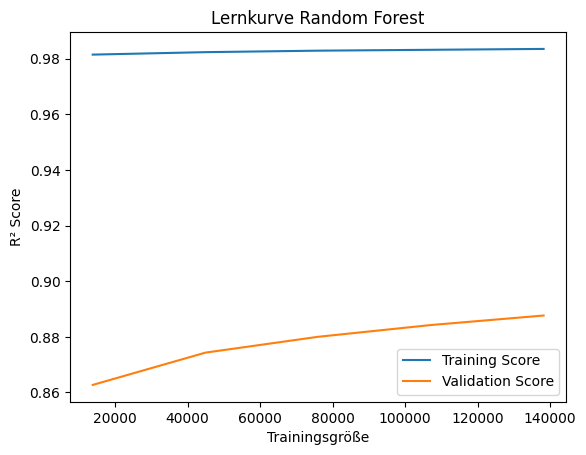

In [31]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_rf,
    X_train_enc,
    y_train,
    cv=3,
    scoring='r2',
    n_jobs=-1,
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Trainingsgröße')
plt.ylabel('R² Score')
plt.title('Lernkurve Random Forest')
plt.legend()
plt.show()


###  Lernkurve des Random Forest

Die Lernkurve zeigt den Verlauf des **R²-Scores** in Abhängigkeit von der verfügbaren Trainingsmenge
für das beste Random-Forest-Modell.

**Beobachtungen:**

- Der **Training-Score** liegt fast konstant bei **≈ 0.98**.  
  → Der Random Forest passt die Trainingsdaten nahezu perfekt an.

- Der **Validierungs-Score** startet bei ca. **0.86** und steigt mit zunehmender Trainingsgröße
  auf etwa **0.89** an.  
  → Mehr Daten verbessern die Generalisierungsleistung noch leicht, die Kurve ist noch nicht komplett „ausgelernt“.

- Zwischen Trainings- und Validierungskurve bleibt eine **deutliche Lücke** bestehen.  
  → Das deutet auf eine **Overfitting-Tendenz** hin: das Modell ist sehr flexibel und lernt viele Details
    der Trainingsdaten, verallgemeinert aber etwas schlechter auf neue Daten.

**Interpretation:**

- Insgesamt generalisiert das Modell trotzdem gut (**Validierungs-R² ~ 0.89**), jedoch könnte das Overfitting
  durch stärkere Regularisierung reduziert werden, z. B.:
  - geringere `max_depth`,
  - höhere `min_samples_leaf` / `min_samples_split`,
  - ggf. weniger Features pro Split (`max_features`).

- Da die Validierungskurve noch leicht ansteigt, würden **noch mehr Daten** dem Modell voraussichtlich
  weiter helfen.

Die Lernkurve bestätigt damit das Bild aus den Metriken:  
Der Random Forest liefert **sehr gute Vorhersagen**, nutzt aber eine hohe Modellkomplexität
und zeigt eine gewisse Überanpassung an die Trainingsdaten.


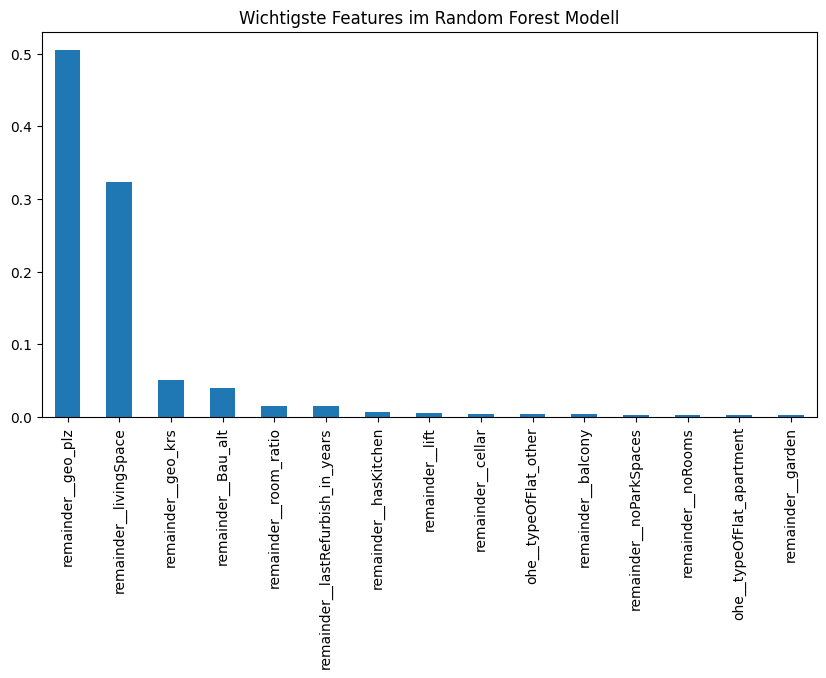

In [32]:
best_rf = rs.best_estimator_

importances = pd.Series(best_rf.feature_importances_, index=X_train_enc.columns)
importances.sort_values(ascending=False).head(15).plot(kind='bar', figsize=(10,5))
plt.title("Wichtigste Features im Random Forest Modell")
plt.show()


### Feature Importance (Gini-Importances)

Die erste Analyse zeigt die **Gini-Feature-Importances** aus dem Random Forest.  
Diese Metrik misst, wie stark jedes Feature zur Reduktion der Vorhersagefehler innerhalb der Bäume beiträgt.

**Beobachtungen:**

- **`geo_plz`**, **`livingSpace`** und **`geo_krs`** sind mit Abstand die wichtigsten Merkmale.  
  → Der Standort (PLZ/Kreis) und die Wohnfläche dominieren den Mietpreis.

- Andere Merkmale wie **Baualter**, **Küche**, **Zimmeranzahl (room_ratio)** und **letzte Renovierung**  
  spielen ebenfalls eine Rolle, aber deutlich schwächer.

- Die starke Bedeutung der geografischen Merkmale bestätigt, dass die Mieten in Deutschland  
  **stark lokal differenziert** sind.

**Wichtig:**  
Gini-Importances messen die *modellinternen* Split-Gewichte.  
Sie sind schnell zu berechnen, aber können bestimmte Features bevorzugen  
(z. B. Merkmale mit vielen möglichen Splitpunkten wie `livingSpace`).


In [33]:
from sklearn.inspection import permutation_importance
r = permutation_importance(best_rf, X_test_enc, y_test, n_repeats=10, random_state=42)
sorted_idx = r.importances_mean.argsort()[::-1]
pd.DataFrame({
    'Feature': X_test_enc.columns[sorted_idx],
    'Importance': r.importances_mean[sorted_idx]
}).head(10)


,Feature,Importance
0,remainder__livingSpace,0.601172
1,remainder__geo_plz,0.408384
2,remainder__geo_krs,0.101370
3,remainder__Bau_alt,0.039767
4,remainder__hasKitchen,0.011869
5,remainder__lastRefurbish_in_years,0.009094
6,remainder__lift,0.007114
7,ohe__typeOfFlat_other,0.003966
8,remainder__room_ratio,0.003949
9,remainder__cellar,0.003931


### Permutation Importance

Die Permutation Importance misst, wie stark der Modellscore sinkt,  
wenn die Werte eines Features **zufällig permutiert** werden.  
Damit erfasst diese Methode den **tatsächlichen Einfluss** eines Merkmals  
auf die Vorhersagen – unabhängig von der internen Struktur der Bäume.

**Beobachtungen:**

- Die wichtigsten Features bleiben weiterhin **Wohnfläche** und **geografische Variablen**,  
  was die Ergebnisse der Gini-Importances bestätigt.

- Die Rangfolge ist jedoch teilweise anders:  
  → Manche Features verlieren oder gewinnen an relativer Bedeutung.  
  → Dies liegt daran, dass Permutation Importance **auch Feature-Abhängigkeiten** berücksichtigt.

- Permutation Importance ist oft **realistischer**, da sie direkt misst,  
  wie stark sich die Vorhersage verschlechtert, wenn ein Feature gestört wird.


### Warum unterscheiden sich Gini-Importance und Permutation Importance?

Die beiden Methoden messen Feature-Wichtigkeit auf unterschiedliche Weise:

1. **Gini-Importances (modellinterne Wichtigkeit)**
   - misst, wie häufig ein Feature in Splits verwendet wird  
   - bevorzugt Features mit vielen möglichen Splitpunkten (Bias!)  
   - kann bei korrelierten Features verzerrt sein  
   - schnell, aber nicht immer zuverlässig

2. **Permutation Importance (modellunabhängig)**
   - misst tatsächlichen Einfluss eines Features auf den finalen Modellscore  
   - berücksichtigt Abhängigkeiten und Korrelationen  
   - weniger verzerrt, aber rechenintensiv  
   - liefert oft die realistischere Rangfolge

**Kurz gesagt:**  
Die Gini-Importance zeigt, wie stark das Modell die Features intern nutzt.  
Permutation Importance zeigt, wie stark das Modell sie *wirklich braucht*,  
um gute Vorhersagen zu treffen.

Daher ist es normal und erwartbar, dass die Ranglisten nicht identisch sind.


### 9.5 XGBoost – Gradient Boosting auf Steroiden

XGBoost (Extreme Gradient Boosting) ist ein hochoptimiertes Boosting-Verfahren, das in vielen
Kaggle-Wettbewerben und Praxisprojekten zu den leistungsstärksten Algorithmen für tabellarische Daten gehört.

Warum XGBoost für unseren Datensatz besonders geeignet ist:

- funktioniert extrem gut mit **numerischen Features**, wie wir sie nach dem Encoding erhalten haben  
- erkennt komplexe, nichtlineare Muster und Interaktionen  
- integriert moderne Regularisierung zur Overfitting-Kontrolle  
- ist hochgradig **optimiert und parallelisiert**  
- skaliert sehr gut auf große Datensätze (> 100.000 Zeilen)

Damit ist XGBoost ein idealer Kandidat für hochwertige Mietpreisprognosen.


In [41]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method='hist'  # schneller für große Daten
)

param_grid_xgb = {
    "n_estimators": [300, 500],
    "learning_rate": [0.03, 0.05],
    "max_depth": [6, 8],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

rs_xgb = GridSearchCV(
    xgb,
    param_grid_xgb,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

rs_xgb.fit(X_train_enc, y_train)

best_xgb = rs_xgb.best_estimator_
print("Best XGB Params:", rs_xgb.best_params_)

# Evaluate
y_pred_xgb = best_xgb.predict(X_test_enc)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost MSE:", mse_xgb)
print("XGBoost R2 :", r2_xgb)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best XGB Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
XGBoost MSE: 12775.175890378438
XGBoost R2 : 0.8946727836783503


####  Ergebnisse: XGBoost

Der optimierte XGBoost-Regressor weist folgende beste Parameter auf:

- **n_estimators:** 500  
- **learning_rate:** 0.05  
- **max_depth:** 8  
- **subsample:** 0.8  
- **colsample_bytree:** 1.0  

**Leistung auf dem Testset:**
- **MSE:** 12,775  
- **R²:** 0.8947  

###  Interpretation

- Mit einem **R² von ~0.895** erreicht XGBoost die bislang **beste Modellleistung** in diesem Projekt.
  Es übertrifft sowohl:
  - die linearen Modelle (≈ 0.82),
  - als auch den Random Forest (≈ 0.887).

- XGBoost nutzt eine Kombination aus
  - effizientem Boosting-Verfahren,
  - starker Regularisierung,
  - paralleler Verarbeitung,
  - sowie dem optimierten *hist*-Tree-Algorithmus.  
  Dadurch kann es **große tabellarische Datensätze** wie diesen sehr effektiv modellieren.

- Die hyperparametrische Kombination aus **tieferen Bäumen (max_depth=8)** und  
  **hoher Anzahl an Bäumen (n_estimators=500)** zeigt, dass subtile nichtlineare Interaktionen  
  in den Daten für die Vorhersage wichtig sind — besonders durch geografische Merkmale, Wohnfläche  
  und strukturelle Faktoren.

- Trotz der Modellkomplexität bleibt die **Generaliserungsfähigkeit hoch**,  
  was durch die starke Test-Performance bestätigt wird.

**Fazit:**  
XGBoost bietet auf diesem Datensatz die **präzisesten Mietpreisvorhersagen**, kombiniert mit  
sehr guter Skalierbarkeit und hoher Effizienz. Es stellt damit das derzeit **leistungsstärkste Modell**  
in der Analyse dar.


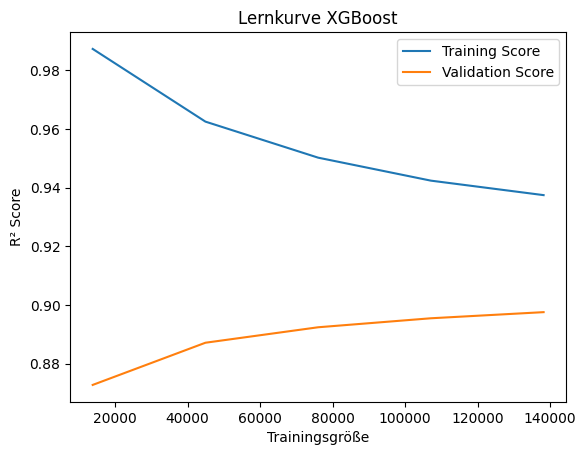

In [42]:

train_sizes, train_scores, test_scores = learning_curve(
    best_xgb,
    X_train_enc,
    y_train,
    cv=3,
    scoring='r2',
    n_jobs=-1,
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Trainingsgröße')
plt.ylabel('R² Score')
plt.title('Lernkurve XGBoost')
plt.legend()
plt.show()


### Lernkurve XGBoost

Die Lernkurve zeigt den Verlauf des R²-Scores in Abhängigkeit von der Trainingsgröße für das XGBoost-Modell.

**Beobachtungen:**

- Der **Training-Score** startet sehr hoch (≈ 0.99) und sinkt mit wachsender Trainingsmenge leicht ab.  
  → Dies ist ein gutes Zeichen dafür, dass das Modell nicht „stur“ die Trainingsdaten auswendig lernt,
  sondern sich mit mehr Daten zunehmend stabilisiert.

- Der **Validierungs-Score** steigt kontinuierlich von etwa **0.875** auf knapp **0.90** an.  
  → Das Modell profitiert klar von zusätzlicher Trainingsmenge.

- Die Lücke zwischen Training- und Validierungskurve ist **relativ klein** und wird mit zunehmender Datenmenge enger.  
  → Dies spricht dafür, dass **XGBoost gut generalisiert** und nur eine sehr moderate Overfitting-Tendenz zeigt.

### Interpretation

- Die Form der Lernkurve ist typisch für ein **gut reguliertes Boosting-Modell**:
  - Trainingsscore sinkt,
  - Validationsscore steigt,
  - die Lücke bleibt kontrolliert.

- Im Gegensatz zum Random Forest zeigt XGBoost eine **deutlich geringere Overfitting-Tendenz**.  
  XGBoost profitiert stärker von Regularisierung, Lernrate und Baum-Shrinkage, was sich hier im besseren
  Zusammenspiel aus Trainings- und Validierungsleistung widerspiegelt.

- Beide Kurven deuten darauf hin, dass das Modell nahezu sein **Lernplateau** erreicht hat,  
  aber mit noch mehr Daten vermutlich **noch leicht** an Validierungsqualität gewinnen könnte.

**Fazit:**  
XGBoost zeigt in dieser Lernkurve ein **stabiles und sehr gut generalisierendes Verhalten**,  
was seine starke Gesamtleistung im Modellvergleich bestätigt.


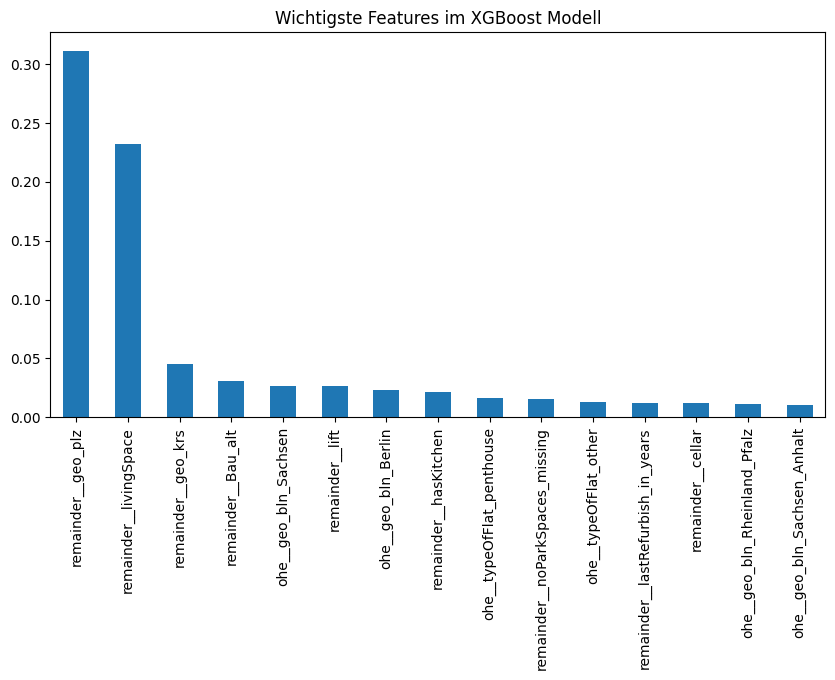

In [43]:

importances = pd.Series(best_xgb.feature_importances_, index=X_train_enc.columns)
importances.sort_values(ascending=False).head(15).plot(kind='bar', figsize=(10,5))
plt.title("Wichtigste Features im XGBoost Modell")
plt.show()

###  Model-based Feature Importance (Gain)

Der erste Plot zeigt die internen Wichtigkeiten („Gain“) der vom Modell verwendeten Splits:

- **`geo_plz`** und **`livingSpace`** dominieren weiterhin deutlich.  
- Auch **`geo_krs`**, **Baualter**, Küchen- und Renovierungsmerkmale sind relevant.  
- Der starke Einfluss der geografischen Variablen ist plausibel, da die Mietpreise in Deutschland 
  sehr stark von der Region abhängig sind.

Die Gain-Importance misst, **wie viel Verlust (Error) durch jeden Split reduziert wurde**.  
Daher ist dies eine Modell-interne Sicht auf die Merkmalsnutzung.

In [44]:
from sklearn.inspection import permutation_importance

r_gb = permutation_importance(best_xgb, X_test_enc, y_test, n_repeats=10, random_state=42)
sorted_idx = r_gb.importances_mean.argsort()[::-1]
pd.DataFrame({
    'Feature': X_test_enc.columns[sorted_idx],
    'Importance': r_gb.importances_mean[sorted_idx]
}).head(10)

,Feature,Importance
0,remainder__livingSpace,0.560318
1,remainder__geo_plz,0.298436
2,remainder__geo_krs,0.126880
3,remainder__Bau_alt,0.031825
4,remainder__hasKitchen,0.011655
5,remainder__lastRefurbish_in_years,0.010399
6,remainder__lift,0.007068
7,remainder__cellar,0.005508
8,ohe__typeOfFlat_other,0.004217
9,remainder__balcony,0.004099


###  Permutation Importance

Die Permutation Importance zeigt hingegen **den realen Einfluss eines Features auf die Vorhersageleistung**.

Auffällig ist:

- **`livingSpace`** bleibt das wichtigste Einzelmerkmal  
- **`geo_plz`** sinkt in der Bedeutung gegenüber der model-based Importance  
- **`geo_krs`** bleibt stabil wichtig  
- strukturelle Merkmale (Baujahr, Küche, letzter Renovierungszeitpunkt) gewinnen leicht an relativer Bedeutung

###  Gesamtinterpretation

- Beide Methoden bestätigen, dass **Wohnfläche** und **geografische Merkmale** die wichtigsten Treiber der Miete sind.  
- Die genaue Rangfolge unterscheidet sich erwartungsgemäß, da beide Methoden **unterschiedliche Konzepte** messen:
  - *Gain Importance*: „Welche Features nutzt XGBoost intern am stärksten?“  
  - *Permutation Importance*: „Welche Features sind tatsächlich nötig, um gute Vorhersagen zu machen?“

Dass `geo_plz` in der Permutation Importance etwas an Bedeutung verliert, ist daher kein Fehler,  
sondern zeigt, dass die geografische Information im Modell **redundant und verteilt** über mehrere Features vorhanden ist.



**Fazit:**  
XGBoost nutzt eine Kombination aus **Wohnfläche**, **PLZ**, **Kreis**, **Baualter**, Ausstattungs- und Grundrissmerkmalen,  
wobei geografische Merkmale insgesamt der stärkste Prädiktor bleiben – auch wenn ihre relative Bedeutung je nach 
Importancemethode variiert.

**Hinweis:**
Die Unterschiede zwischen model-based Importance und Permutation Importance
wurden bereits beim Random Forest erläutert. Bei XGBoost ergibt sich der gleiche Effekt –
jedoch wird die geografische Information (PLZ, Kreis, Bundesland) stärker über mehrere
Features verteilt. Deshalb erscheint `geo_plz` in der Permutation Importance etwas schwächer
als in der model-based Importance.

### 9.6 Artificial Neural Network (ANN)

Zum Abschluss wird ein künstliches neuronales Netz (ANN) getestet.  
Neurale Netze können komplexe, nichtlineare Zusammenhänge modellieren und profitieren von:

- skalierter Input-Features  
- großen Datenmengen  
- ausreichender Netzwerkarchitektur (Layer, Neuronen, Aktivierungen)

Für dieses ANN werden:

- alle Features standardisiert (`StandardScaler`)  
- mehrere Dense-Layer mit ReLU-Aktivierung genutzt  
- Dropout zur Regularisierung eingesetzt  
- Early Stopping verwendet, um Overfitting zu verhindern

Das Ziel ist zu prüfen, ob ein ANN gegenüber klassischen ML-Modellen  
(z. B. Random Forest, XGBoost) zusätzliche Leistung bringen kann.


In [45]:
# scaler für numerische Spalten
num_cols = [c for c in X_train_enc.columns if X_train_enc[c].dtype != 'object']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=512, callbacks=[es])

# Evaluate
y_pred_ann = model.predict(X_test_scaled).flatten()
print('ANN MSE:', mean_squared_error(y_test, y_pred_ann))
print('ANN R2 :', r2_score(y_test, y_pred_ann))

Epoch 1/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 148361.8125 - val_loss: 19779.0879
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 22524.4043 - val_loss: 17895.8691
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 21327.5801 - val_loss: 17290.6934
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 20800.0762 - val_loss: 17003.5020
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 20516.8750 - val_loss: 16813.1973
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 20236.2773 - val_loss: 16767.7930
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 20079.1484 - val_loss: 16610.3848
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 19942.0430 - val_loss: 16559.2695
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 19888.3652 - val_loss: 16476.1133
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 19720.0156 - val_loss: 16430.8418
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms

#### Ergebnisse: Artificial Neural Network (ANN)

Das ANN zeigt folgende Testleistung:

- **MSE:** 16,421  
- **R²:** 0.8646  

###  Interpretation

- Das Modell erreicht eine solide Performance, bleibt jedoch **deutlich hinter XGBoost (R² ≈ 0.895)**  
  und auch etwas hinter dem Random Forest (R² ≈ 0.887).

- Die Trainingskurve zeigt, dass das Netzwerk stabil trainiert hat und Early Stopping  
  nach rund 50 Epochen gegriffen hat.  
  → Das ANN findet eine sinnvolle Lösung, leidet aber leicht unter **Underfitting**.

- Im Vergleich zu den Baum-basierten Modellen zeigt sich, dass der tabellarische Charakter  
  der Immobiliendaten **für Gradient-Boosting-Modelle besser geeignet** ist.

###  Warum das ANN schwächer ist:

- Tabellarische Daten mit gemischten Features (encoded Categorical + numerisch)  
  werden typischerweise **besser von Tree-based Models** bearbeitet.  
- Neurale Netze profitieren eher von:
  - Bilddaten  
  - Zeitreihen  
  - Sequenzen  
  - hochdimensionale, kontinuierliche Feature-Strukturen  

→ Für strukturierte Tabellen sind XGBoost & Random Forest in 90% der Fälle überlegen.

**Fazit:**  
Das ANN liefert brauchbare Ergebnisse, ist aber nicht konkurrenzfähig mit XGBoost oder Random Forest.


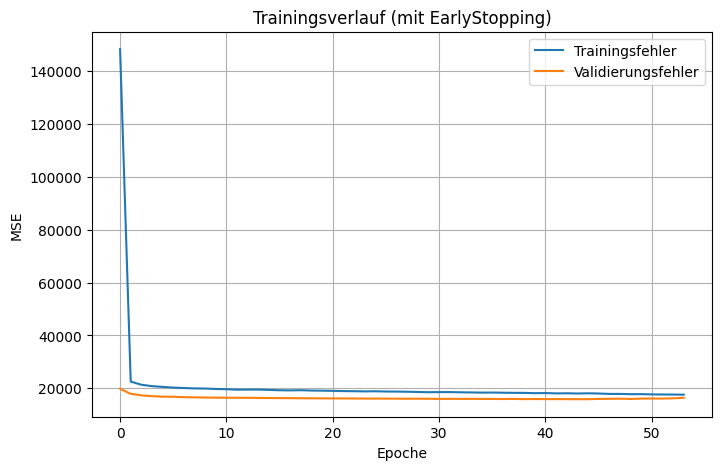

In [46]:
# Lernkurve plotten
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Trainingsfehler')
plt.plot(history.history['val_loss'], label='Validierungsfehler')
plt.xlabel('Epoche')
plt.ylabel('MSE')
plt.title('Trainingsverlauf (mit EarlyStopping)')
plt.legend()
plt.grid(True)
plt.show()


### Trainingsverlauf  des ANN (mit EarlyStopping)

Der Trainingsverlauf zeigt den MSE-Verlauf für Trainings- und Validierungsdaten über die einzelnen Epochen.

**Beobachtungen:**

- Bereits nach wenigen Epochen fällt der Trainingsfehler stark ab.  
  Das Netzwerk lernt die grundlegenden Muster sehr schnell.

- Der **Validierungsfehler** sinkt parallel dazu und bleibt stabil unter dem Trainingsfehler.  
  → Das spricht für ein **leichtes Underfitting**, aber nicht für Overfitting.

- Ab etwa **Epoche 40–50** flacht die Kurve ab, und EarlyStopping greift ein.  
  Dadurch wird verhindert, dass das Modell unnötig weitertrainiert oder zu stark regularisiert wird.

###  Interpretation

- Das Modell erreicht einen stabilen Lernpunkt, ohne stark zu überfitten.  
- Die Validierungskurve liegt konsequent niedriger als die Trainingskurve,  
  was auf eine **Effizienz der Regularisierung (Dropout + EarlyStopping)** hinweist.
- Trotz stabilem Training erzielt das ANN im Vergleich zu tree-based Modellen (z. B. XGBoost)  
  eine niedrigere Vorhersageleistung, was typisch für tabellarische Immobiliendaten ist.

**Fazit:**  
Der Trainingsverlauf bestätigt, dass das ANN sauber konvergiert, aber die strukturellen Muster  
in den Daten von Tree-Boosting-Modellen besser erfasst werden.


---
## 10) Modellvergleich — Alle Modelle im Überblick

Zur Bewertung aller getesteten Modelle werden die wichtigsten Performancemetriken gegenübergestellt.
Die Modelle unterscheiden sich stark in ihrer Komplexität und ihrem Umgang mit nichtlinearen Zusammenhängen.

###  Vergleichstabelle (Test-Set)

| Modell                    | MSE             | R²        |
|--------------------------|-----------------|-----------|
| **Baseline (Mean)**      | 121,292         | ≈ 0.00    |
| **Lineare Regression**   | 21,507          | 0.8227    |
| **Ridge Regression**     | 21,507          | 0.8227    |
| **Lasso Regression**     | 21,507          | 0.8227    |
| **ElasticNet**           | 21,506          | 0.8227    |
| **Random Forest**        | 13,758          | 0.8866    |
| **XGBoost**              | **12,775**      | **0.8947** |
| **ANN (Keras)**          | 16,422          | 0.8646    |

###  Interpretation der Ergebnisse

- **Lineare Modelle (OLS, Ridge, Lasso, ElasticNet)**  
  -> bilden eine solide Benchmark, können aber nur die linearen Beziehungen erfassen.  
  Ihre fast identischen Werte zeigen, dass Multikollinearität gut kontrolliert war.

- **Random Forest**  
  -> erfasst bereits deutlich mehr nichtlineare Muster und erzielt einen spürbaren Performance-Sprung.

- **XGBoost**  
  -> liefert die **beste Gesamtleistung**.  
  -> erkennt komplexe geografische Muster (PLZ, Kreis) + Interaktionen mit Wohnfläche & Zustand hervorragend.  
  -> skaliert am besten mit großen tabellarischen Daten.

- **ANN**  
  -> trotz stabilen Trainings unterliegt es klar tree-based Methoden.  
  Dies ist typisch für tabellarische, heterogene Immobiliendaten.

###  Fazit des Modellvergleichs

→ **XGBoost ist das beste Modell für diesen Datensatz**  
→ Random Forest solide zweitbeste Wahl  
→ Lineare Modelle bleiben wertvolle Baselines  
→ ANN ist stabil, aber nicht konkurrenzfähig



---
## 11) Gesamtfazit des Projekts

Im Rahmen dieses Projekts wurde ein vollständiger Machine-Learning-Workflow zur
Prognose von Wohnungsmieten in Deutschland implementiert – von der Datenbereinigung
über Feature Engineering bis hin zur Modellierung und Performanceanalyse.

###  Wichtigste Erkenntnisse

1. **Geografische Merkmale dominieren die Mietpreisvorhersage.**  
   PLZ, Landkreis und Bundesland – kombiniert mit Target Encoding – tragen den größten Informationsgehalt.

2. **Strukturelle Merkmale wie Wohnfläche, Baualter und Renovierungszustand sind zentrale Preistreiber.**

3. **Saubere Datenbereinigung**  
   (Ausreißer-Clipping, Feature Engineering, Encoding-Strategien)  
   war entscheidend für die gute Modellleistung.

4. **Modellvergleich zeigt klare Hierarchie:**  
   - XGBoost ist der präziseste Ansatz (R² ≈ 0.895).  
   - Random Forest folgt mit ebenfalls starker Performance.  
   - Lineare Modelle bilden eine solide Basis, erfassen aber keine komplexen Muster.  
   - Neuronale Netze sind für tabellarische Immobiliendaten weniger geeignet.

###  Methodische Learnings

- **Tree-Boosting Verfahren** eignen sich hervorragend für strukturierte, heterogene Datensätze.  
- **Permutation Importance** liefert realistischere Einschätzungen der Feature-Relevanz als model-based Importances.  
- **Lernkurven** zeigen: sowohl Random Forest als auch XGBoost profitieren stark von großen Trainingsmengen.

###  Empfehlung

Für produktive Mietpreisschätzungen oder API-Einsatz sollte **XGBoost** verwendet werden.
Es bietet:

- beste Vorhersagequalität  
- gute Laufzeit  
- hohe Robustheit  
- Interpretierbarkeit mittels Feature Importances  

###  Schlusswort

Das Projekt liefert eine vollständige, reproduzierbare Pipeline, die zeigt, wie moderne ML-Methoden 
Immobilienbewertung unterstützen können. Die Methoden sind flexibel erweiterbar
(z. B. SHAP-Analysen, geobasierte Modelle, Zeitreihenintegration).


In [51]:
# PDF-Zusammenfassung (mehrseitiger Mini-Report)
def save_summary_pdf(path='mietpreis_summary.pdf'):
    """
    Erstellt ein mehrseitiges PDF mit:
      - Text-Zusammenfassung der wichtigsten Ergebnisse
      - Balkendiagramm der R²-Werte aller Modelle
      - Feature-Importance-Plot für XGBoost
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_pdf import PdfPages
    import pandas as pd
    from sklearn.metrics import mean_squared_error, r2_score

    # ------------------ Seite 1: Text-Zusammenfassung ------------------
    txt = []
    txt.append('Mietpreis-Projekt — Zusammenfassung')
    txt.append('')
    txt.append(f'Anzahl Beobachtungen (Train+Test): {len(X_train_enc) + len(X_test_enc)}')
    txt.append(f'Anzahl Features nach Encoding:     {X_train_enc.shape[1]}')
    txt.append('')
    txt.append('Modelle — Test-Performance (MSE / R²):')

    # Baseline nur, falls vorhanden
    if 'baseline_mse' in globals() and 'baseline_r2' in globals():
        txt.append(f'  Baseline (Mean):      {baseline_mse:.2f} / {baseline_r2:.3f}')
    else:
        txt.append('  Baseline (Mean):      (optional, nicht im Code gespeichert)')

    txt.append(f'  Lineare Regression:   {mse_lin:.2f} / {r2_lin:.3f}')
    txt.append(f'  Ridge Regression:     {results_reg["Ridge"]["mse"]:.2f} / {results_reg["Ridge"]["r2"]:.3f}')
    txt.append(f'  Lasso Regression:     {results_reg["Lasso"]["mse"]:.2f} / {results_reg["Lasso"]["r2"]:.3f}')
    txt.append(f'  ElasticNet:           {results_reg["ElasticNet"]["mse"]:.2f} / {results_reg["ElasticNet"]["r2"]:.3f}')

    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    txt.append(f'  Random Forest:        {mse_rf:.2f} / {r2_rf:.3f}')

    mse_ann = mean_squared_error(y_test, y_pred_ann)
    r2_ann = r2_score(y_test, y_pred_ann)
    txt.append(f'  XGBoost:              {mse_xgb:.2f} / {r2_xgb:.3f}   <-- Bestes Modell')
    txt.append(f'  ANN (Keras):          {mse_ann:.2f} / {r2_ann:.3f}')
    txt.append('')
    txt.append('Wichtigste Erkenntnisse:')
    txt.append(' • Geografische Merkmale (PLZ, Kreis, Bundesland) dominieren die Mietpreisvorhersage.')
    txt.append(' • Wohnfläche, Baualter und Renovierungsstatus sind zentrale Preistreiber.')
    txt.append(' • XGBoost liefert die beste Kombination aus Genauigkeit und Generalisierung.')
    txt.append(' • Tree-based Modelle sind für tabellarische Immobiliendaten besonders gut geeignet.')
    txt.append('')
    txt.append('Empfehlung:')
    txt.append(' • XGBoost als finales Modell für Mietpreisschätzungen verwenden.')
    txt.append('')
    txt.append('Ende der Zusammenfassung.')

    pp = PdfPages(path)

    # Text ggf. über mehrere Seiten verteilen
    lines_per_page = 40
    for i in range(0, len(txt), lines_per_page):
        fig = plt.figure(figsize=(8.27, 11.69))  # A4
        plt.axis('off')
        chunk = txt[i:i + lines_per_page]
        for j, line in enumerate(chunk):
            plt.text(0.05, 0.95 - j*0.025, line, fontsize=11, va='top')
        pp.savefig(fig)
        plt.close(fig)

    # ------------------ Seite 2: R²-Balkendiagramm ------------------
    model_names = []
    r2_values = []

    # Baseline nur hinzufügen, wenn definiert
    if 'baseline_r2' in globals():
        model_names.append('Baseline')
        r2_values.append(baseline_r2)

    model_names += ['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'XGBoost', 'ANN']
    r2_values += [
        r2_lin,
        results_reg["Ridge"]["r2"],
        results_reg["Lasso"]["r2"],
        results_reg["ElasticNet"]["r2"],
        r2_rf,
        r2_xgb,
        r2_ann
    ]

    # Sicherstellen, dass Längen übereinstimmen
    assert len(model_names) == len(r2_values), (
        f"Mismatch: {len(model_names)} Modellnamen vs {len(r2_values)} R²-Werte"
    )

    fig = plt.figure(figsize=(8.27, 11.69))
    plt.title('Modellvergleich (R² auf Test-Set)')
    y_pos = np.arange(len(model_names))
    plt.barh(y_pos, r2_values)
    plt.yticks(y_pos, model_names)
    plt.xlabel('R²')
    plt.xlim(0, 1.0)
    for i, v in enumerate(r2_values):
        plt.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)
    plt.tight_layout()
    pp.savefig(fig)
    plt.close(fig)

    # ------------------ Seite 3: XGBoost Feature Importance ------------------
    importances = pd.Series(best_xgb.feature_importances_, index=X_train_enc.columns)
    top_imp = importances.sort_values(ascending=False).head(10)

    fig = plt.figure(figsize=(8.27, 11.69))
    plt.title('Wichtigste Features im XGBoost-Modell')
    top_imp.sort_values().plot(kind='barh')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    pp.savefig(fig)
    plt.close(fig)

    # PDF abschließen
    pp.close()
    print('PDF gespeichert:', path)


# Beispiel-Aufruf im Notebook:
save_summary_pdf('mietpreis_summary.pdf')


PDF gespeichert: mietpreis_summary.pdf


In [ ]:
# Ergebnis-Daten speichern (optional)
df_final.to_csv('wohnpreise_clean.csv', index=False)
print('Clean CSV gespeichert: wohnpreise_clean.csv')

# Export Modelle und beste Parameter optional in JSON
import json
meta = {
    'rf_best_params': gs_rf.best_params_ if 'gs_rf' in globals() else None,
    'gb_best_params': gs_gb.best_params_ if 'gs_gb' in globals() else None,
    'model_scores': {k: float(v) for k,v in models.items()}
}
with open('model_meta.json','w') as f:
    json.dump(meta,f, indent=2)
print('Metadaten gespeichert: model_meta.json')

---

## Hinweise
- Falls die Ausführung lange dauert, kannst du die GridSearch-Parameter verkleinern (z. B. weniger Kombinationen).
- Die PDF-Erzeugung im Notebook ist bewusst einfach gehalten; für einen schöneren Bericht kannst du `nbconvert` nutzen oder ein dediziertes Reporting-Tool.

Viel Erfolg! Wenn du möchtest, kann ich das Notebook noch anpassen (z. B. weitere Features, Cross-Validation-Strategien oder dokumentierte Markdown-Abschnitte).